# IMDb Movie Genre Classification Dataset insights

In [1]:
import string
from pathlib import Path

import nltk
import numpy as np
import torch
import pandas as pd
from torch import nn
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from nltk.stem import WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import hamming_loss, classification_report, accuracy_score
from transformers import AutoTokenizer, RobertaForSequenceClassification, BertForSequenceClassification, BertModel

c:\Users\favre\Dev\NLP-IMDbMovieGenreClassification\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEED = 42
N_EPOCH = 20
EMBEDDING_DIM = 64
BERT_EMBEDDING_DIM = 768
HIDDEN_DIM = 96
DROPOUT = 0.2
BATCH_SIZE = 32
DROP_HARD_CLASSES = True
HARD_CLASSES = ["TV Movie", "Western", "Music", "History"]

DATASET_FILENAME = Path("data") / "movies_overview.csv"
GENRES_FILENAME = Path("data") / "movies_genres.csv"

In [3]:
torch.manual_seed(seed=SEED)
np.random.seed(seed=SEED)

# Data analysis and preprocessing

## Load dataset

In [4]:
if not DATASET_FILENAME.exists() or not GENRES_FILENAME.exists():
    raise FileNotFoundError(
        "The dataset file was not found in the data directory! Go to https://www.kaggle.com/datasets/adilshamim8/nlp-task/data, download the dataset and add it to a folder named 'data' in the root directory"
    )

# Read CSV file
full_dataset = pd.read_csv(DATASET_FILENAME)
print(f"Dataset shape: {full_dataset.shape}")
display(full_dataset.head())

movie_genres = pd.read_csv(GENRES_FILENAME).set_index("name").transpose()
print(f"Genres shape: {movie_genres.shape}")
display(movie_genres.head())

Dataset shape: (9980, 3)


,title,overview,genre_ids
0,The Shawshank Redemption,Imprisoned in the 1940s for the double murder ...,"[18, 80]"
1,The Godfather,"Spanning the years 1945 to 1955, a chronicle o...","[18, 80]"
2,The Godfather Part II,In the continuing saga of the Corleone crime f...,"[18, 80]"
3,Schindler's List,The true story of how businessman Oskar Schind...,"[18, 36, 10752]"
4,12 Angry Men,The defense and the prosecution have rested an...,[18]


Genres shape: (1, 19)


name,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
id,28,12,16,35,80,99,18,10751,14,36,27,10402,9648,10749,878,10770,53,10752,37


In [5]:
# Combine genre_ids
for col in movie_genres.columns:
    col_id = str(movie_genres[col]["id"])
    full_dataset[col] = full_dataset["genre_ids"].apply(
        lambda x: col_id in x.strip("[]").replace(" ", "").split(",")
    )
full_dataset.drop(columns=["genre_ids"], inplace=True)
display(full_dataset.head())

,title,overview,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,The Shawshank Redemption,Imprisoned in the 1940s for the double murder ...,False,False,False,False,True,False,True,False,...,False,False,False,False,False,False,False,False,False,False
1,The Godfather,"Spanning the years 1945 to 1955, a chronicle o...",False,False,False,False,True,False,True,False,...,False,False,False,False,False,False,False,False,False,False
2,The Godfather Part II,In the continuing saga of the Corleone crime f...,False,False,False,False,True,False,True,False,...,False,False,False,False,False,False,False,False,False,False
3,Schindler's List,The true story of how businessman Oskar Schind...,False,False,False,False,False,False,True,False,...,True,False,False,False,False,False,False,False,True,False
4,12 Angry Men,The defense and the prosecution have rested an...,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False


In [6]:
full_dataset.describe()

,title,overview,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
count,9980,9980,9980,9980,9980,9980,9980,9980,9980,9980,...,9980,9980,9980,9980,9980,9980,9980,9980,9980,9980
unique,9615,9971,2,2,2,2,2,1,2,2,...,2,2,2,2,2,2,2,2,2,2
top,Return,Humbert Humbert is a middle-aged British novel...,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
freq,13,2,7631,8280,9070,6354,8407,9980,5457,8846,...,9490,8505,9701,9014,8281,8745,9861,7223,9656,9828


## Preprocess data

In [7]:
# Drop duplicates
print(f"Removing {full_dataset.duplicated().sum()} duplicate rows")
full_dataset.drop_duplicates(inplace=True)

Removing 3 duplicate rows


In [8]:
# Drop NaN values
print(f"Removing {full_dataset.isna().any(axis=1).sum()} rows with NaN values")
full_dataset.dropna(inplace=True)

Removing 0 rows with NaN values


In [9]:
# Check that there is movie duplicates
titles = full_dataset["title"]
titles_duplicates = titles.duplicated().sum()
if titles_duplicates > 0:
    print(f"WARNING: Found {titles_duplicates} duplicate titles")
    display(full_dataset[titles.duplicated(keep=False)].sort_values(by="title"))

,title,overview,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
4,12 Angry Men,The defense and the prosecution have rested an...,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
916,12 Angry Men,During the trial of a man accused of his fathe...,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,True,False,False,False
2427,3:10 to Yuma,"In Arizona in the late 1800s, infamous outlaw ...",False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2362,3:10 to Yuma,"Dan Evans, a small time farmer, is hired to es...",False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,True,False,True
1474,A Christmas Carol,Miser Ebenezer Scrooge is awakened on Christma...,False,False,False,False,False,False,True,True,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8098,Wrong Turn,Jen and a group of friends set out to hike the...,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,True,False,False
592,Z,"Amid a tense political climate, the opposition...",False,False,False,False,True,False,True,False,...,False,False,False,False,False,False,False,True,False,False
5262,Z,A family find themselves terrorized by their e...,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,True,False,False
4879,Zulu,"As a child, Ali Neuman narrowly escaped being ...",False,False,False,False,True,False,True,False,...,False,False,False,False,False,False,False,True,False,False


In [10]:
# Check that there is description duplicates
descriptions = full_dataset["overview"]
descriptions_duplicates = descriptions.duplicated().sum()
if descriptions_duplicates > 0:
    print(f"WARNING: Found {descriptions_duplicates} duplicate descriptions")
    display(full_dataset[descriptions.duplicated(keep=False)].sort_values(by="title"))

,title,overview,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
1474,A Christmas Carol,Miser Ebenezer Scrooge is awakened on Christma...,False,False,False,False,False,False,True,True,...,False,False,False,False,False,False,True,False,False,False
3874,A Christmas Carol,Miser Ebenezer Scrooge is awakened on Christma...,False,False,True,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
4197,Charlotte's Web,Wilbur the pig is scared of the end of the sea...,False,False,True,False,False,False,False,True,...,False,False,True,False,False,False,False,False,False,False
7124,Charlotte's Web,Wilbur the pig is scared of the end of the sea...,False,False,False,True,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
1960,Lolita,Humbert Humbert is a middle-aged British novel...,False,False,False,True,False,False,True,False,...,False,False,False,False,True,False,False,False,False,False
2751,Lolita,Humbert Humbert is a middle-aged British novel...,False,False,False,False,False,False,True,False,...,False,False,False,False,True,False,False,False,False,False
4388,Loro 1,"""Loro"", in two parts, is a period movie that c...",False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
2687,Loro 2,"""Loro"", in two parts, is a period movie that c...",False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
2962,The Producers,Broadway producer Max Bialystock and his accou...,False,False,False,True,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
7266,The Producers,Broadway producer Max Bialystock and his accou...,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [11]:
# Combine rows with duplicate descriptions
if descriptions_duplicates > 0:
    duplicate_descriptions = full_dataset[descriptions.duplicated(keep="first")][
        "overview"
    ]
    for descr in duplicate_descriptions:
        full_dataset.loc[full_dataset["overview"] == descr, "title"] = full_dataset.loc[
            full_dataset["overview"] == descr, "title"
        ].iloc[0]
        for col in full_dataset.columns:
            if col != "title" and col != "overview":
                full_dataset.loc[full_dataset["overview"] == descr, col] = (
                    full_dataset.loc[full_dataset["overview"] == descr, col].any()
                )
    full_dataset.drop_duplicates(inplace=True)
    display(full_dataset[descriptions.duplicated(keep=False)].sort_values(by="title"))

C:\Users\favre\AppData\Local\Temp\ipykernel_10640\1040674426.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(full_dataset[descriptions.duplicated(keep=False)].sort_values(by="title"))


,title,overview,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
1474,A Christmas Carol,Miser Ebenezer Scrooge is awakened on Christma...,False,False,True,False,False,False,True,True,...,False,False,False,False,False,False,True,False,False,False
4197,Charlotte's Web,Wilbur the pig is scared of the end of the sea...,False,False,True,True,False,False,False,True,...,False,False,True,False,False,False,False,False,False,False
1960,Lolita,Humbert Humbert is a middle-aged British novel...,False,False,False,True,False,False,True,False,...,False,False,False,False,True,False,False,False,False,False
2687,Loro 2,"""Loro"", in two parts, is a period movie that c...",False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
2962,The Producers,Broadway producer Max Bialystock and his accou...,False,False,False,True,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
4316,The Thomas Crown Affair,Young businessman Thomas Crown is bored and de...,False,False,False,False,True,False,True,False,...,False,False,False,False,True,False,False,False,False,False


## Data insights

### Distributions of genres

In [12]:
def display_categorical_distribution(df, column):
    value_counts = df[column].value_counts()

    plt.figure(layout="compressed", figsize=(6, 6))

    ax = plt.subplot(1, 2, 1)
    plt.pie(
        value_counts,
        autopct="%0.001f%%",
        pctdistance=0.85,
        colors=["skyblue", "yellow"],
    )
    centre_circle = plt.Circle((0, 0), 0.70, fc="white")
    ax.add_artist(centre_circle)

    ax = plt.subplot(1, 2, 2)
    sns.barplot(
        x=value_counts.index,
        y=value_counts.values,
        hue=value_counts.index,
        palette=["skyblue", "yellow"],
        ax=ax,
    )
    plt.xticks(rotation=90)

    plt.title(column)
    plt.show()

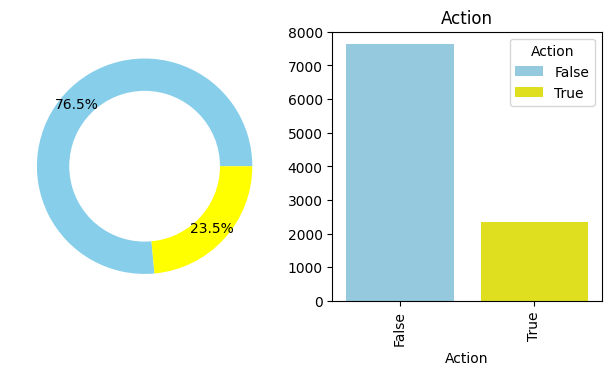

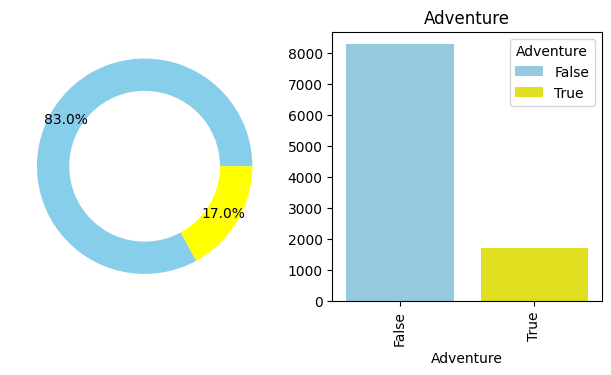

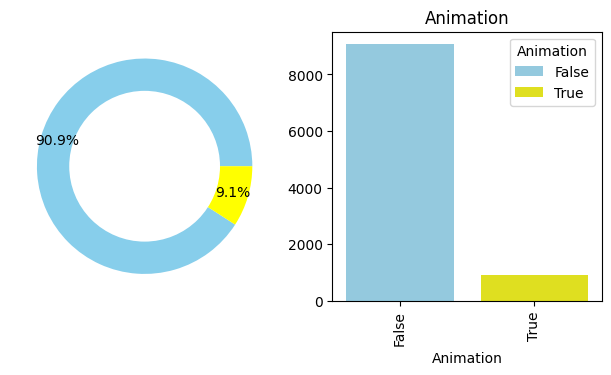

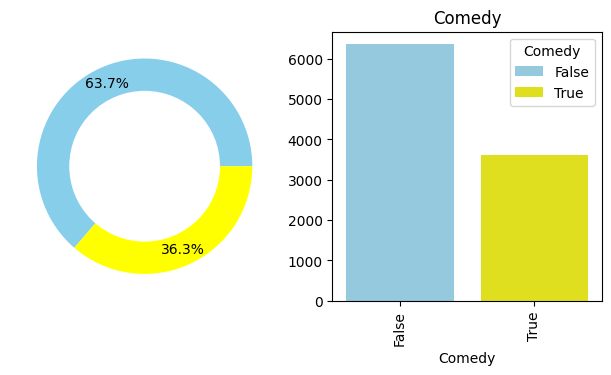

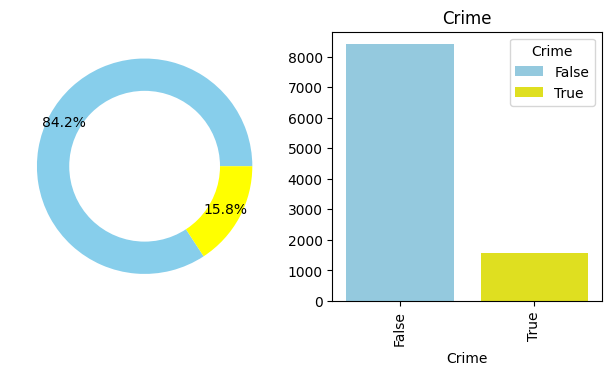

C:\Users\favre\AppData\Local\Temp\ipykernel_10640\2162200160.py:17: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.barplot(


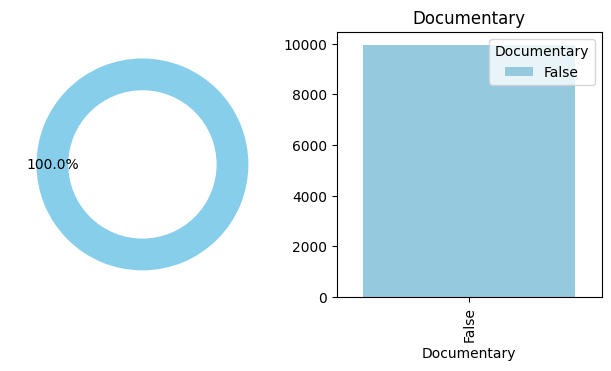

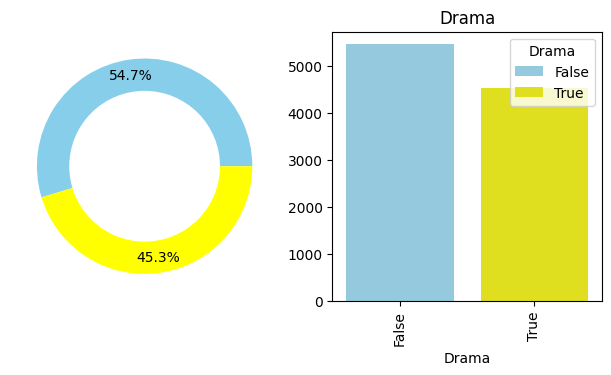

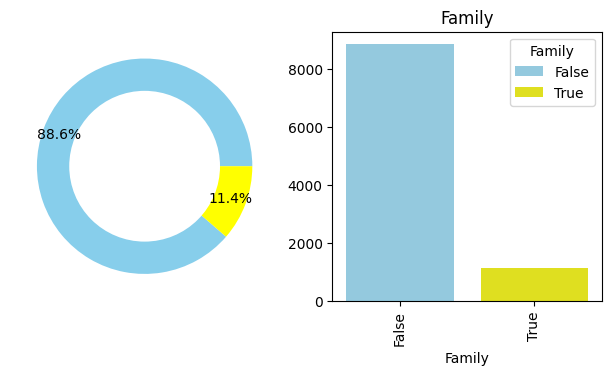

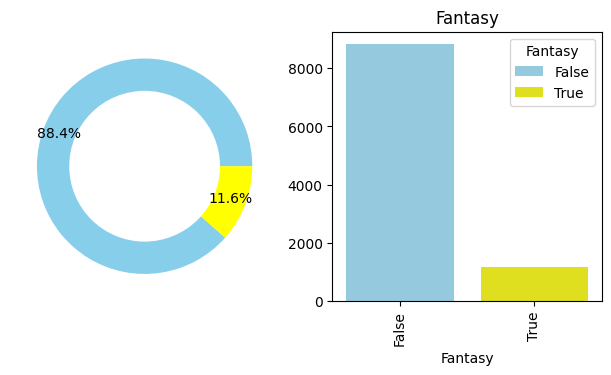

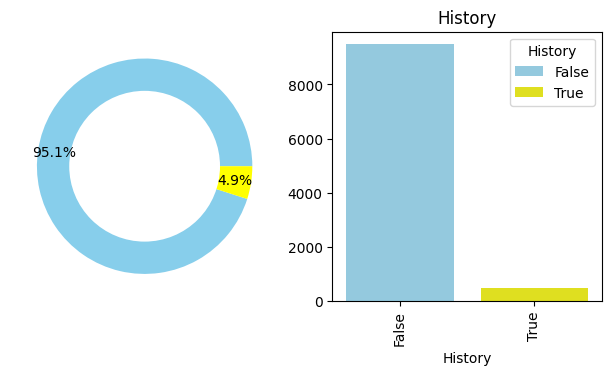

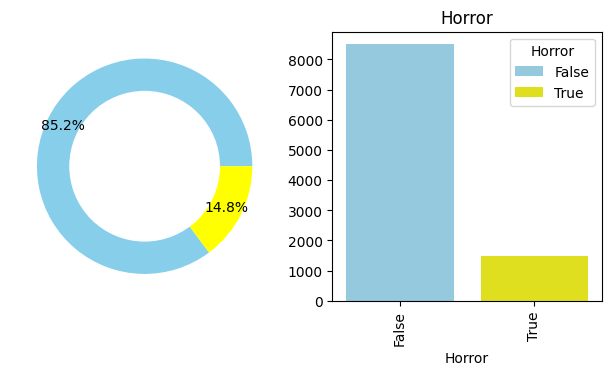

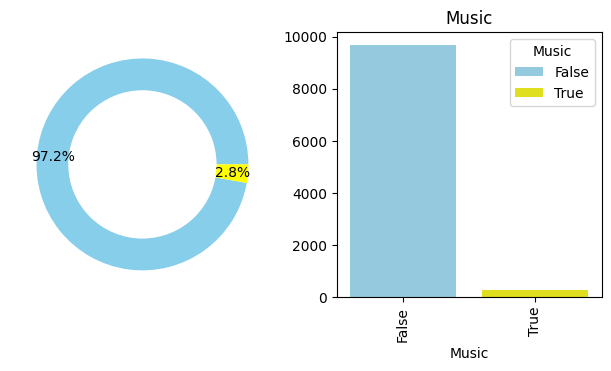

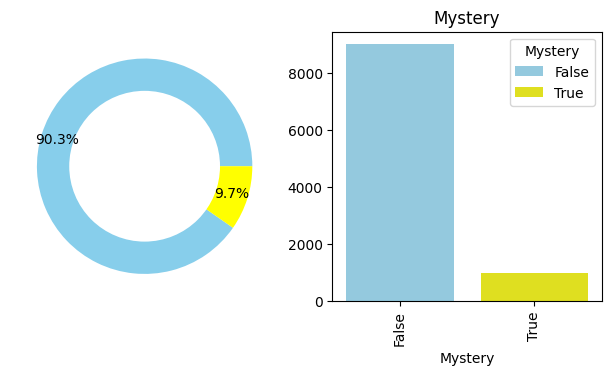

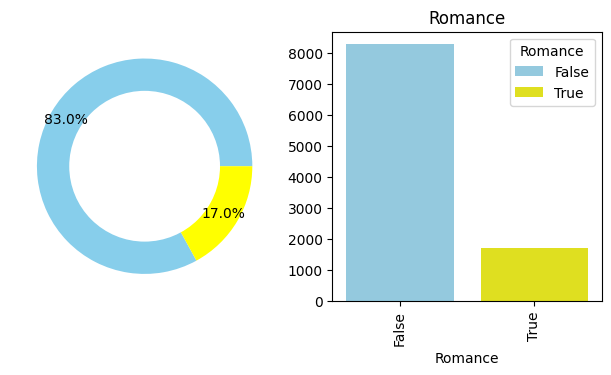

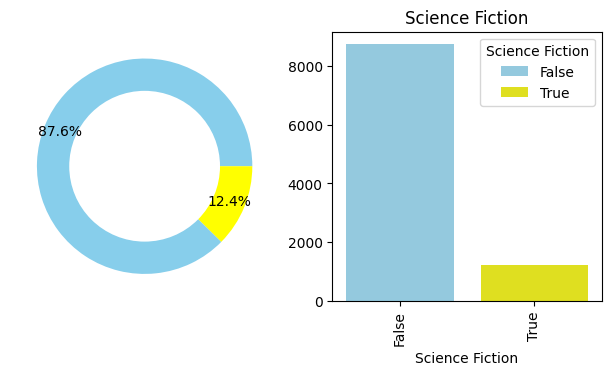

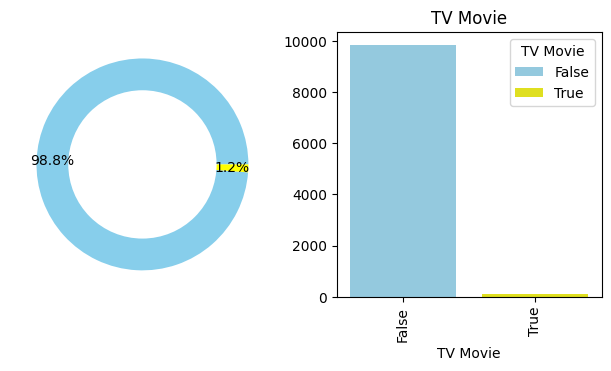

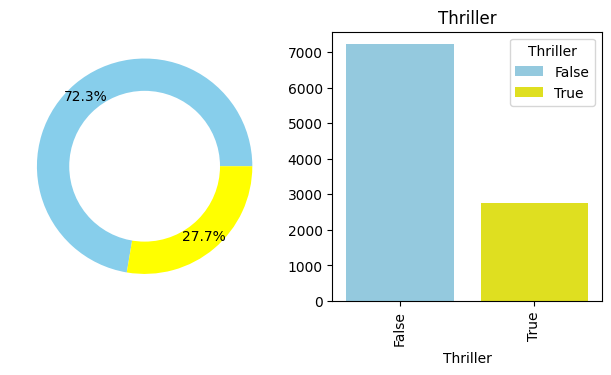

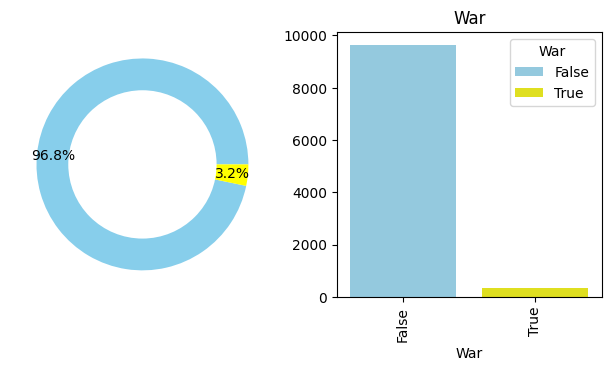

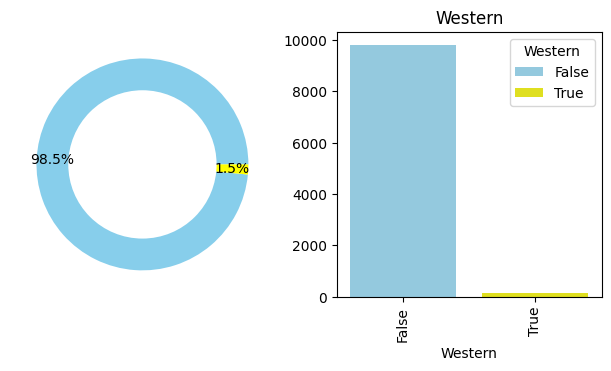

In [13]:
for col in full_dataset.drop(["title", "overview"], axis=1).columns:
    display_categorical_distribution(full_dataset, col)

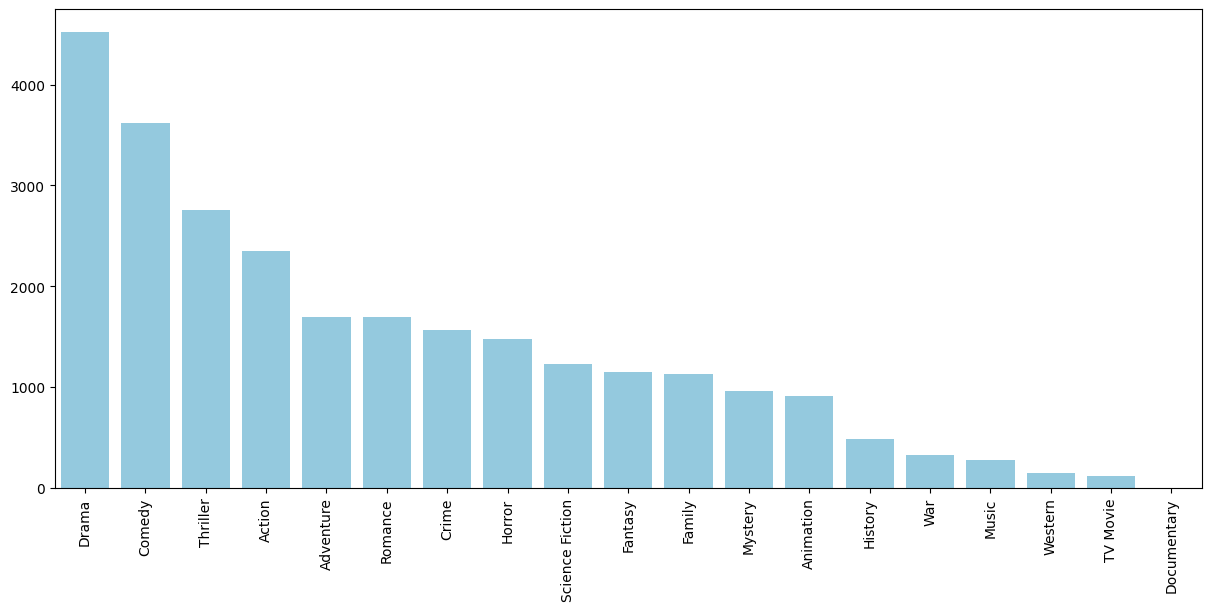

In [14]:
plt.figure(layout="compressed", figsize=(12, 6))
sns.barplot(
    full_dataset.drop(["title", "overview"], axis=1).sum().sort_values(ascending=False),
    color="skyblue",
)
plt.xticks(rotation=90)
plt.show()

### Distribution of the overview text length

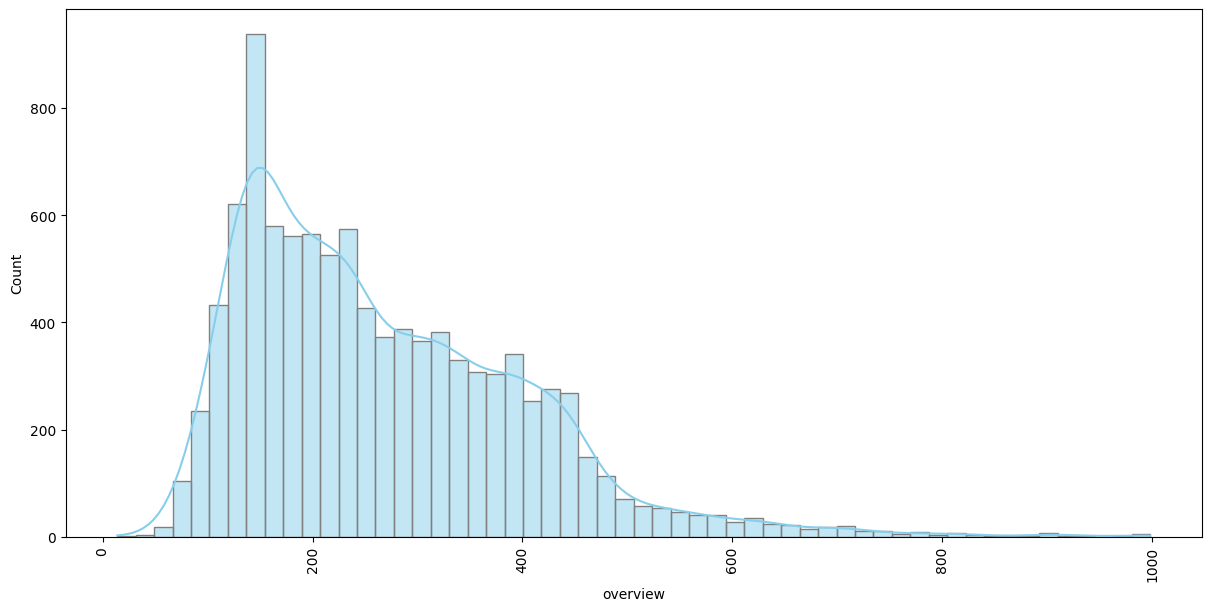

In [15]:
plt.figure(layout="compressed", figsize=(12, 6))
sns.histplot(
    full_dataset["overview"].apply(len),
    kde=True,
    color="skyblue",
    ls="-",
    lw=1,
    edgecolor="gray",
)
plt.xticks(rotation=90)
plt.show()

### Correlation analysis of genres

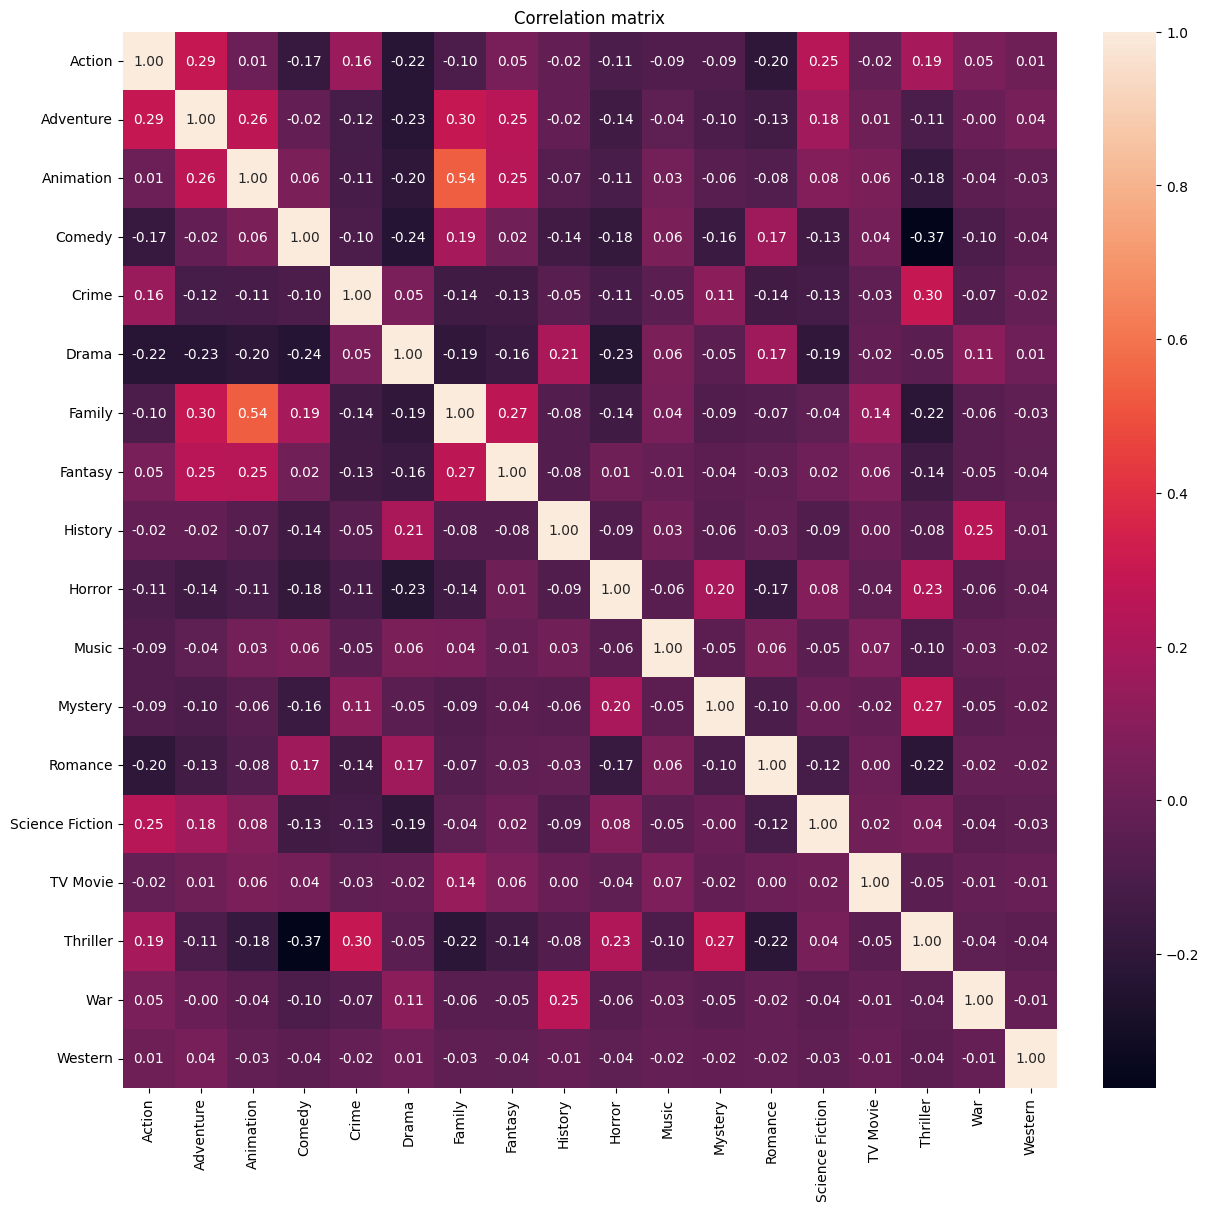

In [16]:
correlation_matrix = full_dataset.drop(
    ["title", "overview", "Documentary"], axis=1
).corr()

plt.figure(layout="compressed", figsize=(12, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title("Correlation matrix")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

## Get dataset

In [17]:
# Drop column with single value
single_value_columns = full_dataset.nunique() == 1
full_dataset.drop(columns=single_value_columns[single_value_columns].index, inplace=True)

# Drop column with single value
if DROP_HARD_CLASSES:
    full_dataset.drop(columns=HARD_CLASSES, inplace=True)

# Drop rows with no associated classes
empty_genre_rows = full_dataset.drop(["title", "overview"], axis=1).any(axis=1)
full_dataset = full_dataset.loc[empty_genre_rows, :]

raw_X = full_dataset["overview"].to_list()
y = full_dataset.drop(["title", "overview"], axis=1).values.astype(int)
y_names = full_dataset.drop(["title", "overview"], axis=1).columns.to_list()
print(f"X shape: {len(raw_X)}, y shape: {y.shape}")

# Shuffle dataset
indices = np.arange(len(raw_X))
np.random.shuffle(indices)

raw_X = [raw_X[index] for index in indices]
y = y[indices]

X shape: 9940, y shape: (9940, 14)


### Clean text and lemmatization

In [18]:
nltk.download("stopwords")
nltk.download("wordnet")


def clean_lemmatized_text(text):
    stop_words = set(stopwords.words("english"))
    lemmatizer = WordNetLemmatizer()
    text = text.translate(str.maketrans("", "", string.punctuation))
    tokens = [
        lemmatizer.lemmatize(word)
        for word in text.lower().split()
        if word not in stop_words
    ]
    return " ".join(tokens)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\favre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\favre\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Function to train scikit model

In [19]:
def train_scikit_model(model, X_train, y_train, X_test, y_test):
    # Train model
    model.fit(X_train, y_train)

    # Evaluate model
    y_pred = model.predict(X_test)
    hamming_acc = 1 - hamming_loss(y_test, y_pred)
    subset_accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(
        y_test, y_pred, zero_division=0, target_names=y_names
    )
    print("Fitted Model Metrics:")
    print(f"  Hamming accuracy: {hamming_acc:.4f}")
    print(f"  Subset accuracy: {subset_accuracy:.4f}")
    print("  Classification report:")
    print(report)
    metrics = {
        "Hamming accuracy": hamming_acc,
        "Subset accuracy": subset_accuracy,
        "classification report": report,
    }

    return model, metrics

### Function to train PyTorch model

In [20]:
def train_pytorch_model(model, X_train, X_train_lengths, y_train, X_test, X_test_lengths, y_test, is_bert=False, lr=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Create DataLoader for training and testing sets
    train_data = torch.utils.data.TensorDataset(X_train, X_train_lengths, y_train)
    test_data = torch.utils.data.TensorDataset(X_test, X_test_lengths, y_test)

    train_loader = torch.utils.data.DataLoader(
        train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=False
    )
    test_loader = torch.utils.data.DataLoader(
        test_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=False
    )

    # Define loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, N_EPOCH)

    # Train model
    model.train()
    model.to(device)
    for i in range(N_EPOCH):
        tot_loss = 0
        for data, text_lengths, target in train_loader:
            data = data.to(device)
            target = target.float().to(device)

            if is_bert:
                input_ids = data[:, :, 0]
                attention_mask = data[:, :, 1]
                output = model(input_ids, attention_mask)
            else:
                output = model(torch.permute(data, (1, 0, 2)), text_lengths)

            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            tot_loss += loss.item() * len(data)
        scheduler.step()
        print(f"Epoch {i + 1}/{N_EPOCH}, Loss: {tot_loss / len(train_data):.4f}")

    # Evaluate model
    model.eval()
    with torch.no_grad():
        y_pred = []
        for data, text_lengths, target in test_loader:
            data = data.to(device)

            if is_bert:
                input_ids = data[:, :, 0]
                attention_mask = data[:, :, 1]
                output = model(input_ids, attention_mask)
            else:
                output = model(torch.permute(data, (1, 0, 2)), text_lengths)

            y_pred.append(output.round().cpu().numpy())
        y_pred = np.vstack(y_pred)

        hamming_acc = 1 - hamming_loss(y_test, y_pred)
        subset_accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(
            y_test, y_pred, zero_division=0, target_names=y_names
        )
        print("Fitted Model Metrics:")
        print(f"  Hamming accuracy: {hamming_acc:.4f}")
        print(f"  Subset accuracy: {subset_accuracy:.4f}")
        print("  Classification report:")
        print(report)
        metrics = {
            "Hamming accuracy": hamming_acc,
            "Subset accuracy": subset_accuracy,
            "classification report": report,
        }

    return model, metrics

### Tokenizers

In [21]:
def tokenize(
    X,
    tokenizer_name="bert-tokenizer",
    do_clean_text=False,
    sentence_representation=None,
):
    X = X.copy()
    if do_clean_text:
        X = [clean_lemmatized_text(review) for review in X]

    # TF-IDF: Term Frequency - Inverse Document Frequency
    if tokenizer_name == "tf-idf":
        vectorizer = TfidfVectorizer(max_features=5000)
        X = vectorizer.fit_transform(X)
    # Word2Vec with Continuous Bag of Words
    elif tokenizer_name == "word2vec-cbow":
        vectorizer = Word2Vec(
            [x.split(" ") for x in X],
            min_count=1,
            vector_size=EMBEDDING_DIM,
            window=5,
            epochs=100,
            seed=SEED,
        )
        word_vectors = vectorizer.wv
        del vectorizer
        word_vectors["[UNK]"] = np.random.rand(EMBEDDING_DIM)
        X = [
            np.stack(
                [
                    (
                        word_vectors[word]
                        if word in word_vectors
                        else word_vectors["[UNK]"]
                    )
                    for word in review.split(" ")
                ]
            )
            for review in X
        ]
    # Word2Vec with Skip-gram
    elif tokenizer_name == "word2vec-skipgram":
        vectorizer = Word2Vec(
            [x.split(" ") for x in X],
            min_count=1,
            vector_size=EMBEDDING_DIM,
            window=5,
            sg=1,
            epochs=100,
            seed=SEED,
        )
        word_vectors = vectorizer.wv
        del vectorizer
        word_vectors["[UNK]"] = np.random.rand(EMBEDDING_DIM)
        X = [
            np.stack(
                [
                    (
                        word_vectors[word]
                        if word in word_vectors
                        else word_vectors["[UNK]"]
                    )
                    for word in review.split(" ")
                ]
            )
            for review in X
        ]
    # BertTokenizer based on WordPiece
    elif tokenizer_name == "bert-embeddings":
        embeddings = BertModel.from_pretrained("bert-base-uncased").get_input_embeddings()
        tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
        X = tokenizer(
            X,
            padding=False,
        )
        with torch.no_grad():
            X = [embeddings(torch.tensor(x)) for x in X["input_ids"]]
    # BertTokenizer based on WordPiece
    elif tokenizer_name == "bert-embeddings-plus":
        model = BertModel.from_pretrained("bert-base-uncased", output_hidden_states=True)
        tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
        context_sensitive_embeddings = []
        for x in X:
            word_embeddings = []
            encoded = tokenizer.encode_plus(
                x,
                padding=False,
                return_tensors="pt",
            )
            with torch.no_grad():
                output = model(**encoded)

            # Get all hidden states
            states = output.hidden_states

            # Stack and sum all requested layers
            output = torch.stack([states[i] for i in [-4, -3, -2, -1]]).sum(0).squeeze()

            for idx in range(len(x.split(" "))):
                # get all token idxs that belong to the word of interest
                token_ids_word = np.where(np.array(encoded.word_ids()) == idx)
            
                # Only select the tokens that constitute the requested word
                word_embeddings.append(output[token_ids_word].mean(dim=0))
            context_sensitive_embeddings.append(word_embeddings)
        X = context_sensitive_embeddings
    # BertTokenizer based on WordPiece
    elif tokenizer_name == "bert-base-tokenizer":
        vectorizer = AutoTokenizer.from_pretrained("bert-base-cased")
        X = vectorizer(
            X,
            padding="longest",
            truncation=True,
            return_attention_mask=True,
        )
        X = np.stack([X["input_ids"], X["attention_mask"]], axis=-1)
    # BertTokenizer based on WordPiece
    elif tokenizer_name == "bert-class-tokenizer":
        vectorizer = AutoTokenizer.from_pretrained(
            "textattack/bert-base-uncased-yelp-polarity"
        )
        X = vectorizer(
            X,
            padding="longest",
            truncation=True,
            return_attention_mask=True,
        )
        X = np.stack([X["input_ids"], X["attention_mask"]], axis=-1)
    # RoBertaTokenizer based on WordPiece
    elif tokenizer_name == "roberta-tokenizer":
        vectorizer = AutoTokenizer.from_pretrained(
            "cardiffnlp/twitter-roberta-base-emotion"
        )
        X = vectorizer(
            X,
            padding="longest",
            truncation=True,
            return_attention_mask=True,
        )
        X = np.stack([X["input_ids"], X["attention_mask"]], axis=-1)
    else:
        raise NotImplementedError(f"Tokenizer not found: {tokenizer_name}")

    if sentence_representation == "average":
        # Combine word vectors using L1-normalized average of word vectors
        X = [
            np.average(x, axis=0) / np.linalg.norm(np.average(x, axis=0), ord=1)
            for x in X
        ]
    elif sentence_representation == "max":
        # Combine word vectors using maximum of word vectors
        X = [np.max(x, axis=0) for x in X]
    elif sentence_representation == "sum":
        # Combine word vectors using L1-normalized sum of word vectors
        X = [np.sum(x, axis=0) for x in X]

    return X

In [22]:
def pad_sequences(X):
    X = X.copy()
    # Combine word vectors by padding into sentence of fixed length
    X_lengths = [len(x) for x in X]
    max_text_length = max(X_lengths)
    X = [
        np.pad(x, ((0, max_text_length - len(x)), (0, 0)), mode="constant")
        for x in X
    ]
    return X, X_lengths

### Models

In [23]:
class RNNClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, bidirectional=False):
        super().__init__()
        self.bidirectional = bidirectional
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=2, dropout=DROPOUT, bidirectional=bidirectional)
        self.dropout = nn.Dropout(DROPOUT)
        self.classifier = nn.Linear(2*hidden_dim if bidirectional else hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, text_lengths):
        packed_output, _ = self.rnn(x)
        rnn_out = packed_output[text_lengths - 1, torch.arange(packed_output.shape[1]), :]
        out = self.classifier(self.dropout(rnn_out))
        if self.training:
            return out
        return self.sigmoid(out)

In [24]:
class LSTMClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, bidirectional=False):
        super().__init__()
        self.bidirectional = bidirectional
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, dropout=DROPOUT, bidirectional=bidirectional)
        self.dropout = nn.Dropout(DROPOUT)
        self.classifier = nn.Linear(2*hidden_dim if bidirectional else hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, text_lengths):
        packed_output, _ = self.lstm(x)
        rnn_out = packed_output[text_lengths - 1, torch.arange(packed_output.shape[1]), :]
        out = self.classifier(self.dropout(rnn_out))
        if self.training:
            return out
        return self.sigmoid(out)

In [25]:
class GRUClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, bidirectional=False):
        super().__init__()
        self.bidirectional = bidirectional
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=2, dropout=DROPOUT, bidirectional=bidirectional)
        self.dropout = nn.Dropout(DROPOUT)
        self.classifier = nn.Linear(2*hidden_dim if bidirectional else hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, text_lengths):
        packed_output, _ = self.gru(x)
        rnn_out = packed_output[text_lengths - 1, torch.arange(packed_output.shape[1]), :]
        out = self.classifier(self.dropout(rnn_out))
        if self.training:
            return out
        return self.sigmoid(out)

In [26]:
class TransformerClassifier(nn.Module):
    def __init__(self, embedding_dim, max_sequence_length, output_dim, nhead=8, num_layers=6):
        super().__init__()
        assert embedding_dim % nhead == 0, "nheads must divide evenly into embedding_dim"

        self.pos_embedding = nn.Embedding(max_sequence_length, embedding_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=nhead,
            dropout=DROPOUT,
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers,
        )
        self.dropout = nn.Dropout(DROPOUT)
        self.classifier = nn.Linear(embedding_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, text_lengths):
        seq_len, batch_size, _ = x.size()
        pos = torch.arange(0, seq_len, device=x.device).unsqueeze(1).repeat(1, batch_size)
        src_key_padding_mask = (torch.arange(seq_len).expand(batch_size, seq_len) >= text_lengths.unsqueeze(1)).to(x.device)
        encoded = self.transformer_encoder(x + self.pos_embedding(pos), src_key_padding_mask=src_key_padding_mask)
        encoded, _ = encoded.max(dim=0)
        out = self.classifier(self.dropout(encoded))

        if self.training:
            return out
        return self.sigmoid(out)

In [27]:
class CustomBertClassifier(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.dropout = nn.Dropout(DROPOUT)
        self.classifier = nn.Linear(BERT_EMBEDDING_DIM, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(
            input_ids=input_ids, attention_mask=attention_mask
        )
        pooler_output = bert_output[1]
        out = self.classifier(self.dropout(pooler_output))
        if self.training:
            return out
        return self.sigmoid(out)

In [28]:
class BertClassifier(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        self.bert_classifier = BertForSequenceClassification.from_pretrained("textattack/bert-base-uncased-yelp-polarity", problem_type="multi_label_classification")
        self.bert_classifier.classifier = nn.Linear(in_features=BERT_EMBEDDING_DIM, out_features=output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        out = self.bert_classifier(input_ids=input_ids, attention_mask=attention_mask).logits
        if self.training:
            return out
        return self.sigmoid(out)

In [29]:
class RoBertaClassifier(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        self.roberta_classifier = RobertaForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-emotion", problem_type="multi_label_classification")
        self.roberta_classifier.classifier.out_proj = nn.Linear(in_features=BERT_EMBEDDING_DIM, out_features=output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        out = self.roberta_classifier(input_ids=input_ids, attention_mask=attention_mask).logits
        if self.training:
            return out
        return self.sigmoid(out)

In [30]:
def get_model(model_name="bert", bidirectional=False, max_text_length=EMBEDDING_DIM, embedding_dim=EMBEDDING_DIM):
    # Multinomial Naive Bayes Classifier
    if model_name == "multinomialnb":
        model = MultiOutputClassifier(MultinomialNB())
    elif model_name == "randomforest":
        model = MultiOutputClassifier(RandomForestClassifier(
            n_estimators=100, criterion="entropy", max_depth=20, random_state=SEED
        ))
    elif model_name == "rnn":
        model = RNNClassifier(embedding_dim, HIDDEN_DIM, y.shape[1], bidirectional=bidirectional)
    elif model_name == "lstm":
        model = LSTMClassifier(embedding_dim, HIDDEN_DIM, y.shape[1], bidirectional=bidirectional)
    elif model_name == "gru":
        model = GRUClassifier(embedding_dim, HIDDEN_DIM, y.shape[1], bidirectional=bidirectional)
    elif model_name == "transformer":
        model = TransformerClassifier(embedding_dim, max_text_length, y.shape[1])
    elif model_name == "bert-custom":
        model = CustomBertClassifier(y.shape[1])
    elif model_name == "bert":
        model = BertClassifier(y.shape[1])
    elif model_name == "roberta":
        model = RoBertaClassifier(y.shape[1])
    else:
        raise NotImplementedError(f"Model not found: {model_name}")

    return model

# Whole overview single vector classifiers

## TF-IDF: Term Frequency - Inverse Document Frequency

In [31]:
print("Raw input data")
print("==============")

# Preprocess data
X = tokenize(raw_X, tokenizer_name="tf-idf", do_clean_text=False)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

# Train Multinomial Naive Bayes Classifier
print("Multinomial Naive Bayes Classifier")
model = get_model(model_name="multinomialnb")
train_scikit_model(model, X_train, y_train, X_test, y_test)

# Train Random Forest Classifier
print("Random Forest Classifier")
model = get_model(model_name="randomforest")
train_scikit_model(model, X_train, y_train, X_test, y_test)

print("Lemmatized input data")
print("=====================")

# Preprocess data
X = tokenize(raw_X, tokenizer_name="tf-idf", do_clean_text=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

# Train Multinomial Naive Bayes Classifier
print("Multinomial Naive Bayes Classifier")
model = get_model(model_name="multinomialnb")
train_scikit_model(model, X_train, y_train, X_test, y_test)

# Train Random Forest Classifier
print("Random Forest Classifier")
model = get_model(model_name="randomforest")
_ = train_scikit_model(model, X_train, y_train, X_test, y_test)

Raw input data
Multinomial Naive Bayes Classifier
Fitted Model Metrics:
  Hamming accuracy: 0.8486
  Subset accuracy: 0.1142
  Classification report:
                 precision    recall  f1-score   support

         Action       0.78      0.28      0.41       471
      Adventure       0.82      0.08      0.15       340
      Animation       1.00      0.03      0.05       182
         Comedy       0.78      0.40      0.53       719
          Crime       0.90      0.11      0.20       318
          Drama       0.69      0.63      0.66       861
         Family       1.00      0.06      0.12       236
        Fantasy       1.00      0.02      0.04       223
         Horror       0.94      0.06      0.11       290
        Mystery       0.00      0.00      0.00       197
        Romance       0.83      0.03      0.06       308
Science Fiction       0.88      0.12      0.21       252
       Thriller       0.73      0.20      0.32       562
            War       0.00      0.00      0.00     

## Word2Vec with Continuous Bag of Words

In [32]:
print("Raw input data")
print("==============")

# Preprocess data
X = tokenize(raw_X, tokenizer_name="word2vec-cbow", do_clean_text=False, sentence_representation="average")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

# Train Random Forest Classifier
print("Random Forest Classifier")
model = get_model(model_name="randomforest")
train_scikit_model(model, X_train, y_train, X_test, y_test)

print("Lemmatized input data")
print("=====================")

# Preprocess data
X = tokenize(raw_X, tokenizer_name="word2vec-cbow", do_clean_text=True, sentence_representation="average")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

# Train Random Forest Classifier
print("Random Forest Classifier")
model = get_model(model_name="randomforest")
_ = train_scikit_model(model, X_train, y_train, X_test, y_test)

Raw input data
Random Forest Classifier
Fitted Model Metrics:
  Hamming accuracy: 0.8400
  Subset accuracy: 0.0926
  Classification report:
                 precision    recall  f1-score   support

         Action       0.70      0.32      0.44       471
      Adventure       0.62      0.11      0.19       340
      Animation       0.00      0.00      0.00       182
         Comedy       0.67      0.38      0.49       719
          Crime       0.76      0.11      0.19       318
          Drama       0.64      0.57      0.60       861
         Family       1.00      0.01      0.03       236
        Fantasy       1.00      0.00      0.01       223
         Horror       0.87      0.09      0.17       290
        Mystery       0.00      0.00      0.00       197
        Romance       0.53      0.08      0.15       308
Science Fiction       0.68      0.09      0.16       252
       Thriller       0.62      0.20      0.31       562
            War       0.86      0.10      0.18        58

   

## Word2Vec with Skipgram

In [33]:
print("Raw input data")
print("==============")

# Preprocess data
X = tokenize(raw_X, tokenizer_name="word2vec-skipgram", do_clean_text=False, sentence_representation="average")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

# Train Random Forest Classifier
print("Random Forest Classifier")
model = get_model(model_name="randomforest")
train_scikit_model(model, X_train, y_train, X_test, y_test)

print("Lemmatized input data")
print("=====================")

# Preprocess data
X = tokenize(raw_X, tokenizer_name="word2vec-skipgram", do_clean_text=True, sentence_representation="average")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

# Train Random Forest Classifier
print("Random Forest Classifier")
model = get_model(model_name="randomforest")
_ = train_scikit_model(model, X_train, y_train, X_test, y_test)

Raw input data
Random Forest Classifier
Fitted Model Metrics:
  Hamming accuracy: 0.8451
  Subset accuracy: 0.1036
  Classification report:
                 precision    recall  f1-score   support

         Action       0.75      0.31      0.44       471
      Adventure       0.68      0.13      0.22       340
      Animation       1.00      0.01      0.02       182
         Comedy       0.69      0.39      0.50       719
          Crime       0.71      0.13      0.22       318
          Drama       0.67      0.61      0.64       861
         Family       0.90      0.04      0.07       236
        Fantasy       0.67      0.01      0.02       223
         Horror       0.89      0.12      0.21       290
        Mystery       0.00      0.00      0.00       197
        Romance       0.62      0.09      0.16       308
Science Fiction       0.93      0.11      0.20       252
       Thriller       0.66      0.20      0.31       562
            War       0.90      0.16      0.26        58

   

## Pretrained embeddings from BERT

In [34]:
print("Raw input data")
print("==============")

# Preprocess data
X = tokenize(raw_X, tokenizer_name="bert-embeddings", do_clean_text=False, sentence_representation="average")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

# Train Random Forest Classifier
print("Random Forest Classifier")
model = get_model(model_name="randomforest")
train_scikit_model(model, X_train, y_train, X_test, y_test)

print("Lemmatized input data")
print("=====================")

# Preprocess data
X = tokenize(raw_X, tokenizer_name="bert-embeddings", do_clean_text=True, sentence_representation="average")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

# Train Random Forest Classifier
print("Random Forest Classifier")
model = get_model(model_name="randomforest")
_ = train_scikit_model(model, X_train, y_train, X_test, y_test)

Raw input data
Random Forest Classifier
Fitted Model Metrics:
  Hamming accuracy: 0.8334
  Subset accuracy: 0.0775
  Classification report:
                 precision    recall  f1-score   support

         Action       0.83      0.08      0.15       471
      Adventure       0.00      0.00      0.00       340
      Animation       0.00      0.00      0.00       182
         Comedy       0.79      0.26      0.39       719
          Crime       0.50      0.00      0.01       318
          Drama       0.65      0.50      0.56       861
         Family       0.00      0.00      0.00       236
        Fantasy       0.00      0.00      0.00       223
         Horror       0.00      0.00      0.00       290
        Mystery       0.00      0.00      0.00       197
        Romance       0.75      0.01      0.02       308
Science Fiction       1.00      0.00      0.01       252
       Thriller       0.66      0.06      0.11       562
            War       0.00      0.00      0.00        58

   

In [35]:
print("Raw input data")
print("==============")

# Preprocess data
X = tokenize(raw_X, tokenizer_name="bert-embeddings-plus", do_clean_text=False, sentence_representation="average")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

# Train Random Forest Classifier
print("Random Forest Classifier with context-sensitive embeddings")
model = get_model(model_name="randomforest")
train_scikit_model(model, X_train, y_train, X_test, y_test)

print("Lemmatized input data")
print("=====================")

# Preprocess data
X = tokenize(raw_X, tokenizer_name="bert-embeddings-plus", do_clean_text=True, sentence_representation="average")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

# Train Random Forest Classifier
print("Random Forest Classifier with context-sensitive embeddings")
model = get_model(model_name="randomforest")
_ = train_scikit_model(model, X_train, y_train, X_test, y_test)

Raw input data
Random Forest Classifier with context-sensitive embeddings
Fitted Model Metrics:
  Hamming accuracy: 0.8608
  Subset accuracy: 0.1353
  Classification report:
                 precision    recall  f1-score   support

         Action       0.75      0.40      0.52       471
      Adventure       0.74      0.26      0.38       340
      Animation       0.85      0.15      0.26       182
         Comedy       0.75      0.50      0.60       719
          Crime       0.78      0.20      0.32       318
          Drama       0.69      0.67      0.68       861
         Family       0.94      0.22      0.35       236
        Fantasy       0.86      0.11      0.19       223
         Horror       0.92      0.15      0.26       290
        Mystery       0.25      0.01      0.01       197
        Romance       0.74      0.19      0.30       308
Science Fiction       0.89      0.35      0.50       252
       Thriller       0.70      0.34      0.45       562
            War       1.00 

# Recurrent classifiers

## TF-IDF: Term Frequency - Inverse Document Frequency

In [36]:
print("Raw input data")
print("==============")

# Preprocess data
X = tokenize(raw_X, tokenizer_name="tf-idf", do_clean_text=False).toarray()[:, np.newaxis, :].astype(np.float32)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)
X_train = torch.from_numpy(X_train)
X_test = torch.from_numpy(X_test)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

# Train RNN Classifier
print("RNN Classifier")
model = get_model(model_name="rnn", bidirectional=False, embedding_dim=5000)
train_pytorch_model(model, X_train, torch.ones(X_train.shape[0], dtype=int), y_train, X_test, torch.ones(X_test.shape[0], dtype=int), y_test)

# Train LSTM Classifier
print("LSTM Classifier")
model = get_model(model_name="lstm", bidirectional=False, embedding_dim=5000)
train_pytorch_model(model, X_train, torch.ones(X_train.shape[0], dtype=int), y_train, X_test, torch.ones(X_test.shape[0], dtype=int), y_test)

# Train GRU Classifier
print("GRU Classifier")
model = get_model(model_name="gru", bidirectional=False, embedding_dim=5000)
train_pytorch_model(model, X_train, torch.ones(X_train.shape[0], dtype=int), y_train, X_test, torch.ones(X_test.shape[0], dtype=int), y_test)

print("Lemmatized input data")
print("=====================")

# Preprocess data
X = tokenize(raw_X, tokenizer_name="tf-idf", do_clean_text=True).toarray()[:, np.newaxis, :].astype(np.float32)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)
X_train = torch.from_numpy(X_train)
X_test = torch.from_numpy(X_test)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

# Train RNN Classifier
print("RNN Classifier")
model = get_model(model_name="rnn", bidirectional=False, embedding_dim=5000)
train_pytorch_model(model, X_train, torch.ones(X_train.shape[0], dtype=int), y_train, X_test, torch.ones(X_test.shape[0], dtype=int), y_test)

# Train LSTM Classifier
print("LSTM Classifier")
model = get_model(model_name="lstm", bidirectional=False, embedding_dim=5000)
train_pytorch_model(model, X_train, torch.ones(X_train.shape[0], dtype=int), y_train, X_test, torch.ones(X_test.shape[0], dtype=int), y_test)

# Train GRU Classifier
print("GRU Classifier")
model = get_model(model_name="gru", bidirectional=False, embedding_dim=5000)
_ = train_pytorch_model(model, X_train, torch.ones(X_train.shape[0], dtype=int), y_train, X_test, torch.ones(X_test.shape[0], dtype=int), y_test)

Raw input data
RNN Classifier
Using device: cuda
Epoch 1/20, Loss: 0.4507
Epoch 2/20, Loss: 0.3604
Epoch 3/20, Loss: 0.2897
Epoch 4/20, Loss: 0.2550
Epoch 5/20, Loss: 0.2305
Epoch 6/20, Loss: 0.2120
Epoch 7/20, Loss: 0.1943
Epoch 8/20, Loss: 0.1791
Epoch 9/20, Loss: 0.1668
Epoch 10/20, Loss: 0.1544
Epoch 11/20, Loss: 0.1440
Epoch 12/20, Loss: 0.1361
Epoch 13/20, Loss: 0.1279
Epoch 14/20, Loss: 0.1224
Epoch 15/20, Loss: 0.1177
Epoch 16/20, Loss: 0.1135
Epoch 17/20, Loss: 0.1116
Epoch 18/20, Loss: 0.1094
Epoch 19/20, Loss: 0.1083
Epoch 20/20, Loss: 0.1079
Fitted Model Metrics:
  Hamming accuracy: 0.8437
  Subset accuracy: 0.1318
  Classification report:
                 precision    recall  f1-score   support

         Action       0.60      0.58      0.59       471
      Adventure       0.54      0.46      0.50       340
      Animation       0.53      0.37      0.43       182
         Comedy       0.60      0.58      0.59       719
          Crime       0.59      0.48      0.53       3

## Word2Vec with Continuous Bag of Words

In [37]:
print("Raw input data")
print("==============")

# Preprocess data
X = tokenize(raw_X, tokenizer_name="word2vec-cbow", do_clean_text=False)
X, X_lengths = pad_sequences(X)
X_train, X_test, X_train_lengths, X_test_lengths, y_train, y_test = train_test_split(
    X, X_lengths, y, test_size=0.2, random_state=SEED
)
X_train = torch.from_numpy(np.array(X_train))
X_test = torch.from_numpy(np.array(X_test))
X_train_lengths = torch.tensor(X_train_lengths)
X_test_lengths = torch.tensor(X_test_lengths)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

# Train RNN Classifier
print("Unidirectional RNN Classifier")
model = get_model(model_name="rnn", bidirectional=False)
train_pytorch_model(model, X_train, X_train_lengths, y_train, X_test, X_test_lengths, y_test)

print("Bidirectional RNN Classifier")
model = get_model(model_name="rnn", bidirectional=True)
train_pytorch_model(model, X_train, X_train_lengths, y_train, X_test, X_test_lengths, y_test)

# Train LSTM Classifier
print("Unidirectional LSTM Classifier")
model = get_model(model_name="lstm", bidirectional=False)
train_pytorch_model(model, X_train, X_train_lengths, y_train, X_test, X_test_lengths, y_test)

print("Bidirectional LSTM Classifier")
model = get_model(model_name="lstm", bidirectional=True)
train_pytorch_model(model, X_train, X_train_lengths, y_train, X_test, X_test_lengths, y_test)

# Train GRU Classifier
print("Unidirectional GRU Classifier")
model = get_model(model_name="gru", bidirectional=False)
train_pytorch_model(model, X_train, X_train_lengths, y_train, X_test, X_test_lengths, y_test)

print("Bidirectional GRU Classifier")
model = get_model(model_name="gru", bidirectional=True)
train_pytorch_model(model, X_train, X_train_lengths, y_train, X_test, X_test_lengths, y_test)

# Train Transformer Classifier
print("Transformer Classifier")
model = get_model(model_name="transformer", max_text_length=len(X[0]))
train_pytorch_model(model, X_train, X_train_lengths, y_train, X_test, X_test_lengths, y_test, lr=1e-4)

print("Lemmatized input data")
print("=====================")

# Preprocess data
X = tokenize(raw_X, tokenizer_name="word2vec-cbow", do_clean_text=True)
X, X_lengths = pad_sequences(X)
X_train, X_test, X_train_lengths, X_test_lengths, y_train, y_test = train_test_split(
    X, X_lengths, y, test_size=0.2, random_state=SEED
)
X_train = torch.from_numpy(np.array(X_train))
X_test = torch.from_numpy(np.array(X_test))
X_train_lengths = torch.tensor(X_train_lengths)
X_test_lengths = torch.tensor(X_test_lengths)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

# Train RNN Classifier
print("Unidirectional RNN Classifier")
model = get_model(model_name="rnn", bidirectional=False)
train_pytorch_model(model, X_train, X_train_lengths, y_train, X_test, X_test_lengths, y_test)

print("Bidirectional RNN Classifier")
model = get_model(model_name="rnn", bidirectional=True)
train_pytorch_model(model, X_train, X_train_lengths, y_train, X_test, X_test_lengths, y_test)

# Train LSTM Classifier
print("Unidirectional LSTM Classifier")
model = get_model(model_name="lstm", bidirectional=False)
train_pytorch_model(model, X_train, X_train_lengths, y_train, X_test, X_test_lengths, y_test)

print("Bidirectional LSTM Classifier")
model = get_model(model_name="lstm", bidirectional=True)
train_pytorch_model(model, X_train, X_train_lengths, y_train, X_test, X_test_lengths, y_test)

# Train GRU Classifier
print("Unidirectional GRU Classifier")
model = get_model(model_name="gru", bidirectional=False)
train_pytorch_model(model, X_train, X_train_lengths, y_train, X_test, X_test_lengths, y_test)

print("Bidirectional GRU Classifier")
model = get_model(model_name="gru", bidirectional=True)
train_pytorch_model(model, X_train, X_train_lengths, y_train, X_test, X_test_lengths, y_test)

# Train Transformer Classifier
print("Transformer Classifier")
model = get_model(model_name="transformer", max_text_length=len(X[0]))
_ = train_pytorch_model(model, X_train, X_train_lengths, y_train, X_test, X_test_lengths, y_test, lr=1e-4)

Raw input data
Unidirectional RNN Classifier
Using device: cuda
Epoch 1/20, Loss: 0.4437
Epoch 2/20, Loss: 0.4269
Epoch 3/20, Loss: 0.4231
Epoch 4/20, Loss: 0.4121
Epoch 5/20, Loss: 0.4054
Epoch 6/20, Loss: 0.4030
Epoch 7/20, Loss: 0.3980
Epoch 8/20, Loss: 0.4045
Epoch 9/20, Loss: 0.4133
Epoch 10/20, Loss: 0.4055
Epoch 11/20, Loss: 0.3950
Epoch 12/20, Loss: 0.3895
Epoch 13/20, Loss: 0.3888
Epoch 14/20, Loss: 0.3902
Epoch 15/20, Loss: 0.3888
Epoch 16/20, Loss: 0.3834
Epoch 17/20, Loss: 0.3804
Epoch 18/20, Loss: 0.3779
Epoch 19/20, Loss: 0.3773
Epoch 20/20, Loss: 0.3766
Fitted Model Metrics:
  Hamming accuracy: 0.8309
  Subset accuracy: 0.0694
  Classification report:
                 precision    recall  f1-score   support

         Action       0.58      0.29      0.39       471
      Adventure       0.57      0.22      0.32       340
      Animation       0.00      0.00      0.00       182
         Comedy       0.62      0.41      0.49       719
          Crime       0.63      0.06   

c:\Users\favre\Dev\NLP-IMDbMovieGenreClassification\.conda\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/20, Loss: 0.4595
Epoch 2/20, Loss: 0.4189
Epoch 3/20, Loss: 0.3887
Epoch 4/20, Loss: 0.3732
Epoch 5/20, Loss: 0.3623
Epoch 6/20, Loss: 0.3564
Epoch 7/20, Loss: 0.3512
Epoch 8/20, Loss: 0.3467
Epoch 9/20, Loss: 0.3445
Epoch 10/20, Loss: 0.3398
Epoch 11/20, Loss: 0.3372
Epoch 12/20, Loss: 0.3348
Epoch 13/20, Loss: 0.3330
Epoch 14/20, Loss: 0.3300
Epoch 15/20, Loss: 0.3293
Epoch 16/20, Loss: 0.3285
Epoch 17/20, Loss: 0.3264
Epoch 18/20, Loss: 0.3255
Epoch 19/20, Loss: 0.3259
Epoch 20/20, Loss: 0.3253
Fitted Model Metrics:
  Hamming accuracy: 0.8417
  Subset accuracy: 0.1142
  Classification report:
                 precision    recall  f1-score   support

         Action       0.59      0.62      0.61       471
      Adventure       0.50      0.41      0.45       340
      Animation       0.44      0.48      0.46       182
         Comedy       0.62      0.67      0.64       719
          Crime       0.61      0.52      0.56       318
          Drama       0.68      0.63      0.66

c:\Users\favre\Dev\NLP-IMDbMovieGenreClassification\.conda\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/20, Loss: 0.4332
Epoch 2/20, Loss: 0.3683
Epoch 3/20, Loss: 0.3510
Epoch 4/20, Loss: 0.3416
Epoch 5/20, Loss: 0.3339
Epoch 6/20, Loss: 0.3295
Epoch 7/20, Loss: 0.3266
Epoch 8/20, Loss: 0.3209
Epoch 9/20, Loss: 0.3180
Epoch 10/20, Loss: 0.3145
Epoch 11/20, Loss: 0.3129
Epoch 12/20, Loss: 0.3105
Epoch 13/20, Loss: 0.3082
Epoch 14/20, Loss: 0.3062
Epoch 15/20, Loss: 0.3037
Epoch 16/20, Loss: 0.3035
Epoch 17/20, Loss: 0.3006
Epoch 18/20, Loss: 0.3004
Epoch 19/20, Loss: 0.3011
Epoch 20/20, Loss: 0.2999
Fitted Model Metrics:
  Hamming accuracy: 0.8545
  Subset accuracy: 0.1378
  Classification report:
                 precision    recall  f1-score   support

         Action       0.62      0.69      0.65       471
      Adventure       0.54      0.57      0.55       340
      Animation       0.47      0.49      0.48       182
         Comedy       0.68      0.60      0.64       719
          Crime       0.64      0.60      0.62       318
          Drama       0.67      0.67      0.67

## Word2Vec with Skipgram

In [38]:
print("Raw input data")
print("==============")

# Preprocess data
X = tokenize(raw_X, tokenizer_name="word2vec-skipgram", do_clean_text=False)
X, X_lengths = pad_sequences(X)
X_train, X_test, X_train_lengths, X_test_lengths, y_train, y_test = train_test_split(
    X, X_lengths, y, test_size=0.2, random_state=SEED
)
X_train = torch.from_numpy(np.array(X_train))
X_test = torch.from_numpy(np.array(X_test))
X_train_lengths = torch.tensor(X_train_lengths)
X_test_lengths = torch.tensor(X_test_lengths)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

# Train RNN Classifier
print("Unidirectional RNN Classifier")
model = get_model(model_name="rnn", bidirectional=False)
train_pytorch_model(model, X_train, X_train_lengths, y_train, X_test, X_test_lengths, y_test)

print("Bidirectional RNN Classifier")
model = get_model(model_name="rnn", bidirectional=True)
train_pytorch_model(model, X_train, X_train_lengths, y_train, X_test, X_test_lengths, y_test)

# Train LSTM Classifier
print("Unidirectional LSTM Classifier")
model = get_model(model_name="lstm", bidirectional=False)
train_pytorch_model(model, X_train, X_train_lengths, y_train, X_test, X_test_lengths, y_test)

print("Bidirectional LSTM Classifier")
model = get_model(model_name="lstm", bidirectional=True)
train_pytorch_model(model, X_train, X_train_lengths, y_train, X_test, X_test_lengths, y_test)

# Train GRU Classifier
print("Unidirectional GRU Classifier")
model = get_model(model_name="gru", bidirectional=False)
train_pytorch_model(model, X_train, X_train_lengths, y_train, X_test, X_test_lengths, y_test)

print("Bidirectional GRU Classifier")
model = get_model(model_name="gru", bidirectional=True)
train_pytorch_model(model, X_train, X_train_lengths, y_train, X_test, X_test_lengths, y_test)

# Train Transformer Classifier
print("Transformer Classifier")
model = get_model(model_name="transformer", max_text_length=len(X[0]))
train_pytorch_model(model, X_train, X_train_lengths, y_train, X_test, X_test_lengths, y_test, lr=1e-4)

print("Lemmatized input data")
print("=====================")

# Preprocess data
X = tokenize(raw_X, tokenizer_name="word2vec-skipgram", do_clean_text=True)
X, X_lengths = pad_sequences(X)
X_train, X_test, X_train_lengths, X_test_lengths, y_train, y_test = train_test_split(
    X, X_lengths, y, test_size=0.2, random_state=SEED
)
X_train = torch.from_numpy(np.array(X_train))
X_test = torch.from_numpy(np.array(X_test))
X_train_lengths = torch.tensor(X_train_lengths)
X_test_lengths = torch.tensor(X_test_lengths)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

# Train RNN Classifier
print("Unidirectional RNN Classifier")
model = get_model(model_name="rnn", bidirectional=False)
train_pytorch_model(model, X_train, X_train_lengths, y_train, X_test, X_test_lengths, y_test)

print("Bidirectional RNN Classifier")
model = get_model(model_name="rnn", bidirectional=True)
train_pytorch_model(model, X_train, X_train_lengths, y_train, X_test, X_test_lengths, y_test)

# Train LSTM Classifier
print("Unidirectional LSTM Classifier")
model = get_model(model_name="lstm", bidirectional=False)
train_pytorch_model(model, X_train, X_train_lengths, y_train, X_test, X_test_lengths, y_test)

print("Bidirectional LSTM Classifier")
model = get_model(model_name="lstm", bidirectional=True)
train_pytorch_model(model, X_train, X_train_lengths, y_train, X_test, X_test_lengths, y_test)

# Train GRU Classifier
print("Unidirectional GRU Classifier")
model = get_model(model_name="gru", bidirectional=False)
train_pytorch_model(model, X_train, X_train_lengths, y_train, X_test, X_test_lengths, y_test)

print("Bidirectional GRU Classifier")
model = get_model(model_name="gru", bidirectional=True)
train_pytorch_model(model, X_train, X_train_lengths, y_train, X_test, X_test_lengths, y_test)

# Train Transformer Classifier
print("Transformer Classifier")
model = get_model(model_name="transformer", max_text_length=len(X[0]))
_ = train_pytorch_model(model, X_train, X_train_lengths, y_train, X_test, X_test_lengths, y_test, lr=1e-4)

Raw input data
Unidirectional RNN Classifier
Using device: cuda
Epoch 1/20, Loss: 0.4470
Epoch 2/20, Loss: 0.4183
Epoch 3/20, Loss: 0.4101
Epoch 4/20, Loss: 0.4076
Epoch 5/20, Loss: 0.4107
Epoch 6/20, Loss: 0.4159
Epoch 7/20, Loss: 0.4110
Epoch 8/20, Loss: 0.4068
Epoch 9/20, Loss: 0.4029
Epoch 10/20, Loss: 0.4206
Epoch 11/20, Loss: 0.4249
Epoch 12/20, Loss: 0.4168
Epoch 13/20, Loss: 0.4123
Epoch 14/20, Loss: 0.4322
Epoch 15/20, Loss: 0.4266
Epoch 16/20, Loss: 0.4206
Epoch 17/20, Loss: 0.4143
Epoch 18/20, Loss: 0.4110
Epoch 19/20, Loss: 0.4091
Epoch 20/20, Loss: 0.4080
Fitted Model Metrics:
  Hamming accuracy: 0.8279
  Subset accuracy: 0.0538
  Classification report:
                 precision    recall  f1-score   support

         Action       0.68      0.04      0.07       471
      Adventure       0.64      0.14      0.24       340
      Animation       0.00      0.00      0.00       182
         Comedy       0.60      0.35      0.44       719
          Crime       0.00      0.00   

c:\Users\favre\Dev\NLP-IMDbMovieGenreClassification\.conda\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/20, Loss: 0.4532
Epoch 2/20, Loss: 0.4112
Epoch 3/20, Loss: 0.3876
Epoch 4/20, Loss: 0.3703
Epoch 5/20, Loss: 0.3609
Epoch 6/20, Loss: 0.3557
Epoch 7/20, Loss: 0.3516
Epoch 8/20, Loss: 0.3474
Epoch 9/20, Loss: 0.3439
Epoch 10/20, Loss: 0.3417
Epoch 11/20, Loss: 0.3406
Epoch 12/20, Loss: 0.3387
Epoch 13/20, Loss: 0.3371
Epoch 14/20, Loss: 0.3352
Epoch 15/20, Loss: 0.3341
Epoch 16/20, Loss: 0.3323
Epoch 17/20, Loss: 0.3316
Epoch 18/20, Loss: 0.3315
Epoch 19/20, Loss: 0.3307
Epoch 20/20, Loss: 0.3300
Fitted Model Metrics:
  Hamming accuracy: 0.8423
  Subset accuracy: 0.1061
  Classification report:
                 precision    recall  f1-score   support

         Action       0.59      0.62      0.60       471
      Adventure       0.52      0.52      0.52       340
      Animation       0.50      0.39      0.44       182
         Comedy       0.62      0.70      0.66       719
          Crime       0.62      0.52      0.57       318
          Drama       0.60      0.78      0.68

c:\Users\favre\Dev\NLP-IMDbMovieGenreClassification\.conda\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/20, Loss: 0.4690
Epoch 2/20, Loss: 0.4117
Epoch 3/20, Loss: 0.3739
Epoch 4/20, Loss: 0.3603
Epoch 5/20, Loss: 0.3505
Epoch 6/20, Loss: 0.3441
Epoch 7/20, Loss: 0.3382
Epoch 8/20, Loss: 0.3349
Epoch 9/20, Loss: 0.3316
Epoch 10/20, Loss: 0.3285
Epoch 11/20, Loss: 0.3272
Epoch 12/20, Loss: 0.3240
Epoch 13/20, Loss: 0.3226
Epoch 14/20, Loss: 0.3206
Epoch 15/20, Loss: 0.3205
Epoch 16/20, Loss: 0.3181
Epoch 17/20, Loss: 0.3181
Epoch 18/20, Loss: 0.3183
Epoch 19/20, Loss: 0.3167
Epoch 20/20, Loss: 0.3163
Fitted Model Metrics:
  Hamming accuracy: 0.8551
  Subset accuracy: 0.1343
  Classification report:
                 precision    recall  f1-score   support

         Action       0.65      0.62      0.64       471
      Adventure       0.56      0.48      0.52       340
      Animation       0.54      0.43      0.48       182
         Comedy       0.66      0.64      0.65       719
          Crime       0.62      0.56      0.59       318
          Drama       0.63      0.76      0.69

## Pretrained embeddings from BERT

In [39]:
print("Raw input data")
print("==============")

# Preprocess data
X = tokenize(raw_X, tokenizer_name="bert-embeddings", do_clean_text=False)
X, X_lengths = pad_sequences(X)
X_train, X_test, X_train_lengths, X_test_lengths, y_train, y_test = train_test_split(
    X, X_lengths, y, test_size=0.2, random_state=SEED
)
X_train = torch.from_numpy(np.array(X_train))
X_test = torch.from_numpy(np.array(X_test))
X_train_lengths = torch.tensor(X_train_lengths)
X_test_lengths = torch.tensor(X_test_lengths)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

# Train RNN Classifier
print("Unidirectional RNN Classifier")
model = get_model(model_name="rnn", bidirectional=False, embedding_dim=BERT_EMBEDDING_DIM)
train_pytorch_model(model, X_train, X_train_lengths, y_train, X_test, X_test_lengths, y_test)

print("Bidirectional RNN Classifier")
model = get_model(model_name="rnn", bidirectional=True, embedding_dim=BERT_EMBEDDING_DIM)
train_pytorch_model(model, X_train, X_train_lengths, y_train, X_test, X_test_lengths, y_test)

# Train LSTM Classifier
print("Unidirectional LSTM Classifier")
model = get_model(model_name="lstm", bidirectional=False, embedding_dim=BERT_EMBEDDING_DIM)
train_pytorch_model(model, X_train, X_train_lengths, y_train, X_test, X_test_lengths, y_test)

print("Bidirectional LSTM Classifier")
model = get_model(model_name="lstm", bidirectional=True, embedding_dim=BERT_EMBEDDING_DIM)
train_pytorch_model(model, X_train, X_train_lengths, y_train, X_test, X_test_lengths, y_test)

# Train GRU Classifier
print("Unidirectional GRU Classifier")
model = get_model(model_name="gru", bidirectional=False, embedding_dim=BERT_EMBEDDING_DIM)
train_pytorch_model(model, X_train, X_train_lengths, y_train, X_test, X_test_lengths, y_test)

print("Bidirectional GRU Classifier")
model = get_model(model_name="gru", bidirectional=True, embedding_dim=BERT_EMBEDDING_DIM)
train_pytorch_model(model, X_train, X_train_lengths, y_train, X_test, X_test_lengths, y_test)

# Train Transformer Classifier
print("Transformer Classifier")
model = get_model(model_name="transformer", max_text_length=len(X[0]), embedding_dim=BERT_EMBEDDING_DIM)
train_pytorch_model(model, X_train, X_train_lengths, y_train, X_test, X_test_lengths, y_test, lr=1e-4)

print("Lemmatized input data")
print("=====================")

# Preprocess data
X = tokenize(raw_X, tokenizer_name="bert-embeddings", do_clean_text=True)
X, X_lengths = pad_sequences(X)
X_train, X_test, X_train_lengths, X_test_lengths, y_train, y_test = train_test_split(
    X, X_lengths, y, test_size=0.2, random_state=SEED
)
X_train = torch.from_numpy(np.array(X_train))
X_test = torch.from_numpy(np.array(X_test))
X_train_lengths = torch.tensor(X_train_lengths)
X_test_lengths = torch.tensor(X_test_lengths)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

# Train RNN Classifier
print("Unidirectional RNN Classifier")
model = get_model(model_name="rnn", bidirectional=False, embedding_dim=BERT_EMBEDDING_DIM)
train_pytorch_model(model, X_train, X_train_lengths, y_train, X_test, X_test_lengths, y_test)

print("Bidirectional RNN Classifier")
model = get_model(model_name="rnn", bidirectional=True, embedding_dim=BERT_EMBEDDING_DIM)
train_pytorch_model(model, X_train, X_train_lengths, y_train, X_test, X_test_lengths, y_test)

# Train LSTM Classifier
print("Unidirectional LSTM Classifier")
model = get_model(model_name="lstm", bidirectional=False, embedding_dim=BERT_EMBEDDING_DIM)
train_pytorch_model(model, X_train, X_train_lengths, y_train, X_test, X_test_lengths, y_test)

print("Bidirectional LSTM Classifier")
model = get_model(model_name="lstm", bidirectional=True, embedding_dim=BERT_EMBEDDING_DIM)
train_pytorch_model(model, X_train, X_train_lengths, y_train, X_test, X_test_lengths, y_test)

# Train GRU Classifier
print("Unidirectional GRU Classifier")
model = get_model(model_name="gru", bidirectional=False, embedding_dim=BERT_EMBEDDING_DIM)
train_pytorch_model(model, X_train, X_train_lengths, y_train, X_test, X_test_lengths, y_test)

print("Bidirectional GRU Classifier")
model = get_model(model_name="gru", bidirectional=True, embedding_dim=BERT_EMBEDDING_DIM)
train_pytorch_model(model, X_train, X_train_lengths, y_train, X_test, X_test_lengths, y_test)

# Train Transformer Classifier
print("Transformer Classifier")
model = get_model(model_name="transformer", max_text_length=len(X[0]), embedding_dim=BERT_EMBEDDING_DIM)
_ = train_pytorch_model(model, X_train, X_train_lengths, y_train, X_test, X_test_lengths, y_test, lr=1e-4)

Raw input data
Unidirectional RNN Classifier
Using device: cuda
Epoch 1/20, Loss: 0.4498
Epoch 2/20, Loss: 0.4421
Epoch 3/20, Loss: 0.4381
Epoch 4/20, Loss: 0.4269
Epoch 5/20, Loss: 0.4199
Epoch 6/20, Loss: 0.4111
Epoch 7/20, Loss: 0.4000
Epoch 8/20, Loss: 0.3898
Epoch 9/20, Loss: 0.3869
Epoch 10/20, Loss: 0.3809
Epoch 11/20, Loss: 0.3648
Epoch 12/20, Loss: 0.3548
Epoch 13/20, Loss: 0.3452
Epoch 14/20, Loss: 0.3373
Epoch 15/20, Loss: 0.3314
Epoch 16/20, Loss: 0.3273
Epoch 17/20, Loss: 0.3221
Epoch 18/20, Loss: 0.3193
Epoch 19/20, Loss: 0.3170
Epoch 20/20, Loss: 0.3159
Fitted Model Metrics:
  Hamming accuracy: 0.8295
  Subset accuracy: 0.0850
  Classification report:
                 precision    recall  f1-score   support

         Action       0.54      0.32      0.40       471
      Adventure       0.50      0.25      0.34       340
      Animation       0.41      0.14      0.21       182
         Comedy       0.55      0.45      0.50       719
          Crime       0.50      0.20   

c:\Users\favre\Dev\NLP-IMDbMovieGenreClassification\.conda\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/20, Loss: 0.4480
Epoch 2/20, Loss: 0.4415
Epoch 3/20, Loss: 0.4404
Epoch 4/20, Loss: 0.4394
Epoch 5/20, Loss: 0.4390
Epoch 6/20, Loss: 0.4380
Epoch 7/20, Loss: 0.4385
Epoch 8/20, Loss: 0.4381
Epoch 9/20, Loss: 0.4378
Epoch 10/20, Loss: 0.4374
Epoch 11/20, Loss: 0.4369
Epoch 12/20, Loss: 0.4368
Epoch 13/20, Loss: 0.4367
Epoch 14/20, Loss: 0.4363
Epoch 15/20, Loss: 0.4364
Epoch 16/20, Loss: 0.4362
Epoch 17/20, Loss: 0.4360
Epoch 18/20, Loss: 0.4358
Epoch 19/20, Loss: 0.4356
Epoch 20/20, Loss: 0.4354
Fitted Model Metrics:
  Hamming accuracy: 0.8126
  Subset accuracy: 0.0025
  Classification report:
                 precision    recall  f1-score   support

         Action       0.00      0.00      0.00       471
      Adventure       0.00      0.00      0.00       340
      Animation       0.00      0.00      0.00       182
         Comedy       0.00      0.00      0.00       719
          Crime       0.00      0.00      0.00       318
          Drama       0.40      0.08      0.14

c:\Users\favre\Dev\NLP-IMDbMovieGenreClassification\.conda\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/20, Loss: 0.4474
Epoch 2/20, Loss: 0.4412
Epoch 3/20, Loss: 0.4395
Epoch 4/20, Loss: 0.4389
Epoch 5/20, Loss: 0.4385
Epoch 6/20, Loss: 0.4380
Epoch 7/20, Loss: 0.4380
Epoch 8/20, Loss: 0.4381
Epoch 9/20, Loss: 0.4375
Epoch 10/20, Loss: 0.4371
Epoch 11/20, Loss: 0.4369
Epoch 12/20, Loss: 0.4367
Epoch 13/20, Loss: 0.4367
Epoch 14/20, Loss: 0.4365
Epoch 15/20, Loss: 0.4364
Epoch 16/20, Loss: 0.4361
Epoch 17/20, Loss: 0.4359
Epoch 18/20, Loss: 0.4354
Epoch 19/20, Loss: 0.4350
Epoch 20/20, Loss: 0.4349
Fitted Model Metrics:
  Hamming accuracy: 0.8102
  Subset accuracy: 0.0810
  Classification report:
                 precision    recall  f1-score   support

         Action       0.00      0.00      0.00       471
      Adventure       0.00      0.00      0.00       340
      Animation       0.00      0.00      0.00       182
         Comedy       0.00      0.00      0.00       719
          Crime       0.00      0.00      0.00       318
          Drama       0.43      1.00      0.60

In [40]:
print("Raw input data")
print("==============")

# Preprocess data
X = tokenize(raw_X, tokenizer_name="bert-embeddings-plus", do_clean_text=False)
X, X_lengths = pad_sequences(X)
X_train, X_test, X_train_lengths, X_test_lengths, y_train, y_test = train_test_split(
    X, X_lengths, y, test_size=0.2, random_state=SEED
)
X_train = torch.from_numpy(np.array(X_train))
X_test = torch.from_numpy(np.array(X_test))
X_train_lengths = torch.tensor(X_train_lengths)
X_test_lengths = torch.tensor(X_test_lengths)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

# Train RNN Classifier
print("Unidirectional RNN Classifier")
model = get_model(model_name="rnn", bidirectional=False, embedding_dim=BERT_EMBEDDING_DIM)
train_pytorch_model(model, X_train, X_train_lengths, y_train, X_test, X_test_lengths, y_test)

print("Bidirectional RNN Classifier")
model = get_model(model_name="rnn", bidirectional=True, embedding_dim=BERT_EMBEDDING_DIM)
train_pytorch_model(model, X_train, X_train_lengths, y_train, X_test, X_test_lengths, y_test)

# Train LSTM Classifier
print("Unidirectional LSTM Classifier")
model = get_model(model_name="lstm", bidirectional=False, embedding_dim=BERT_EMBEDDING_DIM)
train_pytorch_model(model, X_train, X_train_lengths, y_train, X_test, X_test_lengths, y_test)

print("Bidirectional LSTM Classifier")
model = get_model(model_name="lstm", bidirectional=True, embedding_dim=BERT_EMBEDDING_DIM)
train_pytorch_model(model, X_train, X_train_lengths, y_train, X_test, X_test_lengths, y_test)

# Train GRU Classifier
print("Unidirectional GRU Classifier")
model = get_model(model_name="gru", bidirectional=False, embedding_dim=BERT_EMBEDDING_DIM)
train_pytorch_model(model, X_train, X_train_lengths, y_train, X_test, X_test_lengths, y_test)

print("Bidirectional GRU Classifier")
model = get_model(model_name="gru", bidirectional=True, embedding_dim=BERT_EMBEDDING_DIM)
train_pytorch_model(model, X_train, X_train_lengths, y_train, X_test, X_test_lengths, y_test)

# Train Transformer Classifier
print("Transformer Classifier")
model = get_model(model_name="transformer", max_text_length=len(X[0]), embedding_dim=BERT_EMBEDDING_DIM)
train_pytorch_model(model, X_train, X_train_lengths, y_train, X_test, X_test_lengths, y_test, lr=1e-4)

print("Lemmatized input data")
print("=====================")

# Preprocess data
X = tokenize(raw_X, tokenizer_name="bert-embeddings-plus", do_clean_text=True)
X, X_lengths = pad_sequences(X)
X_train, X_test, X_train_lengths, X_test_lengths, y_train, y_test = train_test_split(
    X, X_lengths, y, test_size=0.2, random_state=SEED
)
X_train = torch.from_numpy(np.array(X_train))
X_test = torch.from_numpy(np.array(X_test))
X_train_lengths = torch.tensor(X_train_lengths)
X_test_lengths = torch.tensor(X_test_lengths)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

# Train RNN Classifier
print("Unidirectional RNN Classifier")
model = get_model(model_name="rnn", bidirectional=False, embedding_dim=BERT_EMBEDDING_DIM)
train_pytorch_model(model, X_train, X_train_lengths, y_train, X_test, X_test_lengths, y_test)

print("Bidirectional RNN Classifier")
model = get_model(model_name="rnn", bidirectional=True, embedding_dim=BERT_EMBEDDING_DIM)
train_pytorch_model(model, X_train, X_train_lengths, y_train, X_test, X_test_lengths, y_test)

# Train LSTM Classifier
print("Unidirectional LSTM Classifier")
model = get_model(model_name="lstm", bidirectional=False, embedding_dim=BERT_EMBEDDING_DIM)
train_pytorch_model(model, X_train, X_train_lengths, y_train, X_test, X_test_lengths, y_test)

print("Bidirectional LSTM Classifier")
model = get_model(model_name="lstm", bidirectional=True, embedding_dim=BERT_EMBEDDING_DIM)
train_pytorch_model(model, X_train, X_train_lengths, y_train, X_test, X_test_lengths, y_test)

# Train GRU Classifier
print("Unidirectional GRU Classifier")
model = get_model(model_name="gru", bidirectional=False, embedding_dim=BERT_EMBEDDING_DIM)
train_pytorch_model(model, X_train, X_train_lengths, y_train, X_test, X_test_lengths, y_test)

print("Bidirectional GRU Classifier")
model = get_model(model_name="gru", bidirectional=True, embedding_dim=BERT_EMBEDDING_DIM)
train_pytorch_model(model, X_train, X_train_lengths, y_train, X_test, X_test_lengths, y_test)

# Train Transformer Classifier
print("Transformer Classifier")
model = get_model(model_name="transformer", max_text_length=len(X[0]), embedding_dim=BERT_EMBEDDING_DIM)
_ = train_pytorch_model(model, X_train, X_train_lengths, y_train, X_test, X_test_lengths, y_test, lr=1e-4)

Raw input data
Unidirectional RNN Classifier
Using device: cuda
Epoch 1/20, Loss: 0.4247
Epoch 2/20, Loss: 0.3556
Epoch 3/20, Loss: 0.3306
Epoch 4/20, Loss: 0.3156
Epoch 5/20, Loss: 0.3015
Epoch 6/20, Loss: 0.2911
Epoch 7/20, Loss: 0.2813
Epoch 8/20, Loss: 0.2704
Epoch 9/20, Loss: 0.2598
Epoch 10/20, Loss: 0.2517
Epoch 11/20, Loss: 0.2412
Epoch 12/20, Loss: 0.2330
Epoch 13/20, Loss: 0.2249
Epoch 14/20, Loss: 0.2172
Epoch 15/20, Loss: 0.2133
Epoch 16/20, Loss: 0.2089
Epoch 17/20, Loss: 0.2056
Epoch 18/20, Loss: 0.2029
Epoch 19/20, Loss: 0.2010
Epoch 20/20, Loss: 0.2004
Fitted Model Metrics:
  Hamming accuracy: 0.8620
  Subset accuracy: 0.1595
  Classification report:
                 precision    recall  f1-score   support

         Action       0.65      0.62      0.64       471
      Adventure       0.59      0.53      0.56       340
      Animation       0.59      0.47      0.52       182
         Comedy       0.68      0.66      0.67       719
          Crime       0.58      0.50   

c:\Users\favre\Dev\NLP-IMDbMovieGenreClassification\.conda\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/20, Loss: 0.3420
Epoch 2/20, Loss: 0.2771
Epoch 3/20, Loss: 0.2451
Epoch 4/20, Loss: 0.2152
Epoch 5/20, Loss: 0.1797
Epoch 6/20, Loss: 0.1489
Epoch 7/20, Loss: 0.1140
Epoch 8/20, Loss: 0.0850
Epoch 9/20, Loss: 0.0613
Epoch 10/20, Loss: 0.0441
Epoch 11/20, Loss: 0.0282
Epoch 12/20, Loss: 0.0190
Epoch 13/20, Loss: 0.0129
Epoch 14/20, Loss: 0.0094
Epoch 15/20, Loss: 0.0072
Epoch 16/20, Loss: 0.0058
Epoch 17/20, Loss: 0.0052
Epoch 18/20, Loss: 0.0047
Epoch 19/20, Loss: 0.0044
Epoch 20/20, Loss: 0.0043
Fitted Model Metrics:
  Hamming accuracy: 0.8567
  Subset accuracy: 0.1323
  Classification report:
                 precision    recall  f1-score   support

         Action       0.62      0.75      0.68       471
      Adventure       0.52      0.60      0.56       340
      Animation       0.55      0.68      0.61       182
         Comedy       0.66      0.73      0.69       719
          Crime       0.52      0.65      0.58       318
          Drama       0.65      0.79      0.72

c:\Users\favre\Dev\NLP-IMDbMovieGenreClassification\.conda\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/20, Loss: 0.3542
Epoch 2/20, Loss: 0.2953
Epoch 3/20, Loss: 0.2685
Epoch 4/20, Loss: 0.2360
Epoch 5/20, Loss: 0.2050
Epoch 6/20, Loss: 0.1730
Epoch 7/20, Loss: 0.1391
Epoch 8/20, Loss: 0.1094
Epoch 9/20, Loss: 0.0854
Epoch 10/20, Loss: 0.0631
Epoch 11/20, Loss: 0.0440
Epoch 12/20, Loss: 0.0304
Epoch 13/20, Loss: 0.0220
Epoch 14/20, Loss: 0.0152
Epoch 15/20, Loss: 0.0116
Epoch 16/20, Loss: 0.0095
Epoch 17/20, Loss: 0.0081
Epoch 18/20, Loss: 0.0074
Epoch 19/20, Loss: 0.0070
Epoch 20/20, Loss: 0.0065
Fitted Model Metrics:
  Hamming accuracy: 0.8451
  Subset accuracy: 0.1107
  Classification report:
                 precision    recall  f1-score   support

         Action       0.62      0.69      0.65       471
      Adventure       0.51      0.59      0.55       340
      Animation       0.54      0.59      0.56       182
         Comedy       0.63      0.73      0.67       719
          Crime       0.49      0.62      0.55       318
          Drama       0.62      0.78      0.69

## BERT

In [41]:
print("Raw input data")
print("==============")

# Preprocess data
X = tokenize(raw_X, tokenizer_name="bert-base-tokenizer", do_clean_text=False)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)
X_train = torch.from_numpy(np.array(X_train))
X_test = torch.from_numpy(np.array(X_test))
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

# Train BERT Classifier
print("Custom BERT Classifier")
model = get_model(model_name="bert-custom")
train_pytorch_model(model, X_train, torch.ones(X_train.shape[0], dtype=int), y_train, X_test, torch.ones(X_test.shape[0], dtype=int), y_test, is_bert=True, lr=2e-5)

print("Lemmatized input data")
print("=====================")

# Preprocess data
X = tokenize(raw_X, tokenizer_name="bert-base-tokenizer", do_clean_text=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)
X_train = torch.from_numpy(np.array(X_train))
X_test = torch.from_numpy(np.array(X_test))
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)
1
214# Train BERT Classifier
print("Custom BERT Classifier")
model = get_model(model_name="bert-custom")
_ = train_pytorch_model(model, X_train, torch.ones(X_train.shape[0], dtype=int), y_train, X_test, torch.ones(X_test.shape[0], dtype=int), y_test, is_bert=True, lr=2e-5)

Raw input data
Custom BERT Classifier
Using device: cuda
Epoch 1/20, Loss: 0.4547
Epoch 2/20, Loss: 0.4214
Epoch 3/20, Loss: 0.3832
Epoch 4/20, Loss: 0.3417
Epoch 5/20, Loss: 0.3043
Epoch 6/20, Loss: 0.2739
Epoch 7/20, Loss: 0.2449
Epoch 8/20, Loss: 0.2217
Epoch 9/20, Loss: 0.2003
Epoch 10/20, Loss: 0.1833
Epoch 11/20, Loss: 0.1681
Epoch 12/20, Loss: 0.1555
Epoch 13/20, Loss: 0.1463
Epoch 14/20, Loss: 0.1364
Epoch 15/20, Loss: 0.1308
Epoch 16/20, Loss: 0.1250
Epoch 17/20, Loss: 0.1215
Epoch 18/20, Loss: 0.1191
Epoch 19/20, Loss: 0.1182
Epoch 20/20, Loss: 0.1176
Fitted Model Metrics:
  Hamming accuracy: 0.8483
  Subset accuracy: 0.1283
  Classification report:
                 precision    recall  f1-score   support

         Action       0.63      0.60      0.61       471
      Adventure       0.57      0.39      0.47       340
      Animation       0.49      0.19      0.27       182
         Comedy       0.62      0.60      0.61       719
          Crime       0.53      0.43      0.48

In [42]:
print("Raw input data")
print("==============")

# Preprocess data
X = tokenize(raw_X, tokenizer_name="bert-class-tokenizer", do_clean_text=False)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)
X_train = torch.from_numpy(np.array(X_train))
X_test = torch.from_numpy(np.array(X_test))
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

# Train BERT Classifier
print("BERT Classifier")
model = get_model(model_name="bert")
train_pytorch_model(model, X_train, torch.ones(X_train.shape[0], dtype=int), y_train, X_test, torch.ones(X_test.shape[0], dtype=int), y_test, is_bert=True, lr=2e-5)

print("Lemmatized input data")
print("=====================")

# Preprocess data
X = tokenize(raw_X, tokenizer_name="bert-class-tokenizer", do_clean_text=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)
X_train = torch.from_numpy(np.array(X_train))
X_test = torch.from_numpy(np.array(X_test))
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

# Train BERT Classifier
print("BERT Classifier")
model = get_model(model_name="bert")
_ = train_pytorch_model(model, X_train, torch.ones(X_train.shape[0], dtype=int), y_train, X_test, torch.ones(X_test.shape[0], dtype=int), y_test, is_bert=True, lr=2e-5)

Raw input data
BERT Classifier
Using device: cuda
Epoch 1/20, Loss: 0.4614
Epoch 2/20, Loss: 0.3676
Epoch 3/20, Loss: 0.3291
Epoch 4/20, Loss: 0.2934
Epoch 5/20, Loss: 0.2624
Epoch 6/20, Loss: 0.2367
Epoch 7/20, Loss: 0.2171
Epoch 8/20, Loss: 0.1992
Epoch 9/20, Loss: 0.1829
Epoch 10/20, Loss: 0.1700
Epoch 11/20, Loss: 0.1590
Epoch 12/20, Loss: 0.1503
Epoch 13/20, Loss: 0.1426
Epoch 14/20, Loss: 0.1365
Epoch 15/20, Loss: 0.1317
Epoch 16/20, Loss: 0.1283
Epoch 17/20, Loss: 0.1255
Epoch 18/20, Loss: 0.1239
Epoch 19/20, Loss: 0.1222
Epoch 20/20, Loss: 0.1212
Fitted Model Metrics:
  Hamming accuracy: 0.8676
  Subset accuracy: 0.1645
  Classification report:
                 precision    recall  f1-score   support

         Action       0.69      0.65      0.67       471
      Adventure       0.60      0.56      0.58       340
      Animation       0.59      0.48      0.53       182
         Comedy       0.66      0.70      0.68       719
          Crime       0.60      0.55      0.57       

## RoBERTa

In [43]:
print("Raw input data")
print("==============")

# Preprocess data
X = tokenize(raw_X, tokenizer_name="roberta-tokenizer", do_clean_text=False)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)
X_train = torch.from_numpy(np.array(X_train))
X_test = torch.from_numpy(np.array(X_test))
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

# Train RoBERTa Classifier
print("RoBERTa Classifier")
model = get_model(model_name="roberta")
train_pytorch_model(model, X_train, torch.ones(X_train.shape[0], dtype=int), y_train, X_test, torch.ones(X_test.shape[0], dtype=int), y_test, is_bert=True, lr=2e-5)

print("Lemmatized input data")
print("=====================")

# Preprocess data
X = tokenize(raw_X, tokenizer_name="roberta-tokenizer", do_clean_text=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)
X_train = torch.from_numpy(np.array(X_train))
X_test = torch.from_numpy(np.array(X_test))
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

# Train RoBERTa Classifier
print("RoBERTa Classifier")
model = get_model(model_name="roberta")
_ = train_pytorch_model(model, X_train, torch.ones(X_train.shape[0], dtype=int), y_train, X_test, torch.ones(X_test.shape[0], dtype=int), y_test, is_bert=True, lr=2e-5)

Raw input data


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


RoBERTa Classifier
Using device: cuda
Epoch 1/20, Loss: 0.3730
Epoch 2/20, Loss: 0.2810
Epoch 3/20, Loss: 0.2431
Epoch 4/20, Loss: 0.2157
Epoch 5/20, Loss: 0.1891
Epoch 6/20, Loss: 0.1676
Epoch 7/20, Loss: 0.1474
Epoch 8/20, Loss: 0.1309
Epoch 9/20, Loss: 0.1154
Epoch 10/20, Loss: 0.1026
Epoch 11/20, Loss: 0.0916
Epoch 12/20, Loss: 0.0815
Epoch 13/20, Loss: 0.0737
Epoch 14/20, Loss: 0.0683
Epoch 15/20, Loss: 0.0631
Epoch 16/20, Loss: 0.0591
Epoch 17/20, Loss: 0.0569
Epoch 18/20, Loss: 0.0555
Epoch 19/20, Loss: 0.0540
Epoch 20/20, Loss: 0.0535
Fitted Model Metrics:
  Hamming accuracy: 0.8801
  Subset accuracy: 0.2007
  Classification report:
                 precision    recall  f1-score   support

         Action       0.69      0.70      0.70       471
      Adventure       0.63      0.58      0.60       340
      Animation       0.69      0.59      0.63       182
         Comedy       0.76      0.66      0.71       719
          Crime       0.64      0.60      0.62       318
        

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


RoBERTa Classifier
Using device: cuda
Epoch 1/20, Loss: 0.3773
Epoch 2/20, Loss: 0.2973
Epoch 3/20, Loss: 0.2611
Epoch 4/20, Loss: 0.2318
Epoch 5/20, Loss: 0.2055
Epoch 6/20, Loss: 0.1844
Epoch 7/20, Loss: 0.1641
Epoch 8/20, Loss: 0.1484
Epoch 9/20, Loss: 0.1321
Epoch 10/20, Loss: 0.1192
Epoch 11/20, Loss: 0.1078
Epoch 12/20, Loss: 0.0985
Epoch 13/20, Loss: 0.0906
Epoch 14/20, Loss: 0.0839
Epoch 15/20, Loss: 0.0790
Epoch 16/20, Loss: 0.0751
Epoch 17/20, Loss: 0.0722
Epoch 18/20, Loss: 0.0706
Epoch 19/20, Loss: 0.0693
Epoch 20/20, Loss: 0.0692
Fitted Model Metrics:
  Hamming accuracy: 0.8748
  Subset accuracy: 0.1836
  Classification report:
                 precision    recall  f1-score   support

         Action       0.70      0.67      0.68       471
      Adventure       0.64      0.53      0.58       340
      Animation       0.68      0.50      0.58       182
         Comedy       0.73      0.63      0.68       719
          Crime       0.62      0.58      0.60       318
        